## Imports necessarios

In [1]:
import pandas as pd
import numpy as np

# Preparação dos Dados

In [2]:
nba = pd.read_csv("NBA_Dataset.csv")

Normalizando para os "NaN" = 0

In [3]:
nba = nba.fillna(0)

### Visualizando as posições existentes no df

In [4]:
nba["pos"].unique()

array(['C', 'SF', 'SG', 'PG', 'PF', 'C-PF', 'PF-C', 'SF-SG', 'SF-PF',
       'PG-SG', 'SG-PG', 'PF-SF', 'SG-SF', 'PG-SF', 'SG-PF', 'SF-C',
       'SG-PG-SF'], dtype=object)

In [5]:
nba["pos"].value_counts()

pos
PF          3633
C           3579
SG          3562
PG          3372
SF          3292
SF-SG         39
PG-SG         33
SG-SF         32
C-PF          31
PF-C          31
SG-PG         31
PF-SF         31
SF-PF         24
SG-PF          4
PG-SF          1
SF-C           1
SG-PG-SF       1
Name: count, dtype: int64

Dupliquei jogadores com mais de uma posição, tornando-o duas linhas no df, uma para cada pos dele. Por exemplo: um jogador cuja "pos" é SF-SG agora tem duas linhas, uma como SF, outra como SG. O objetivo aqui é obter somente PF, C, SG, PG, e SF

In [6]:
def expand_positions(df):
    new_rows = []  
    for index, row in df.iterrows():
        positions = row['pos'].split('-')
        for pos in positions:
            new_row = row.copy()
            new_row['pos'] = pos
            new_rows.append(new_row)
    return pd.DataFrame(new_rows)

mask = nba['pos'].str.contains('-')  
expanded_rows = expand_positions(nba[mask])
single_position_rows = nba[~mask]  

nba_new = pd.concat([single_position_rows, expanded_rows]).reset_index(drop=True)

#### Novo value counts

In [7]:
nba_new["pos"].value_counts()

pos
PF    3754
SG    3702
C     3642
PG    3438
SF    3421
Name: count, dtype: int64

### Dividindo a base de dados em 5 (um df para cada posição)

In [8]:
nba_PF = nba_new[nba_new["pos"] == "PF"]
nba_SG = nba_new[nba_new["pos"] == "SG"]
nba_C = nba_new[nba_new["pos"] == "C"]
nba_PG = nba_new[nba_new["pos"] == "PG"]
nba_SF = nba_new[nba_new["pos"] == "SF"]

Os candidatos ao MVP são aqueles que "award_share" > 0. Ou seja, receberam votos para serem MVP de determinada temporada

In [9]:
candidatos_PF = nba_PF[nba_PF["award_share"] > 0]
candidatos_SG = nba_SG[nba_SG["award_share"] > 0]
candidatos_C = nba_C[nba_C["award_share"] > 0]
candidatos_PG = nba_PG[nba_PG["award_share"] > 0]
candidatos_SF = nba_SF[nba_SF["award_share"] > 0]

In [10]:
candidatos = nba_new[nba_new["award_share"] > 0]
candidatos = candidatos[candidatos["season"] >= 1995]
candidatos["pos"].value_counts()

pos
PG    113
PF     94
C      76
SG     73
SF     65
Name: count, dtype: int64

# Avaliando candidatos PF

## Selecionando métricas

#### Correlação

In [11]:
correlations_PF = candidatos_PF.corr(numeric_only=True)['award_share'].sort_values(ascending=False)
print(correlations_PF)

award_share         1.000000
bpm                 0.624955
vorp                0.620328
ws_per_48           0.619663
per                 0.601075
ws                  0.567939
obpm                0.530586
dbpm                0.496430
ast_pct             0.481062
ows                 0.469908
win_loss_pct        0.413538
ast_per_g           0.412371
usg_pct             0.399441
fg_per_g            0.391556
pts_per_g           0.387624
fg2_per_g           0.386817
dws                 0.374406
mov                 0.370386
mov_adj             0.357928
fta_per_g           0.339824
ft_per_g            0.305180
drb_per_g           0.301519
fga_per_g           0.296321
fg2a_per_g          0.288286
tov_per_g           0.263529
drb_pct             0.241658
fg2_pct             0.233169
fg_pct              0.205829
efg_pct             0.200849
ts_pct              0.200302
blk_pct             0.195072
blk_per_g           0.185687
trb_per_g           0.146722
stl_per_g           0.140884
gs            

In [12]:
print(correlations_PF.head(11))

award_share     1.000000
bpm             0.624955
vorp            0.620328
ws_per_48       0.619663
per             0.601075
ws              0.567939
obpm            0.530586
dbpm            0.496430
ast_pct         0.481062
ows             0.469908
win_loss_pct    0.413538
Name: award_share, dtype: float64


In [13]:
print(correlations_PF.head(11).sum() - correlations_PF.head(1).sum())

5.425483164079248


#### Random Forest

In [14]:
# Dropping rows where any value is missing
candidatos_PF.dropna(inplace=True)

# Or dropping columns with more than a certain percentage of missing values
threshold = 0.3  # Threshold to drop columns, e.g., if more than 30% values are missing
candidatos_PF.dropna(axis=1, thresh=int(threshold * len(candidatos_PF)), inplace=True)

# Replace inf/-inf with NaN (then you can fill NaN as shown above)
candidatos_PF.replace([np.inf, -np.inf], np.nan, inplace=True)

candidatos_PF = candidatos_PF.apply(pd.to_numeric, errors='ignore')

C:\Users\l3598\AppData\Local\Temp\ipykernel_15232\1929508025.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidatos_PF.dropna(inplace=True)
C:\Users\l3598\AppData\Local\Temp\ipykernel_15232\1929508025.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidatos_PF.dropna(axis=1, thresh=int(threshold * len(candidatos_PF)), inplace=True)
C:\Users\l3598\AppData\Local\Temp\ipykernel_15232\1929508025.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Preparing the data
X = candidatos_PF.drop('award_share', axis=1)
y = candidatos_PF['award_share']

# Convert categorical columns to numeric using Label Encoding or One-Hot Encoding
# Here using Label Encoding as an example
label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creating and fitting the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importance
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display the feature importances
print(importances.head(12))

ws_per_48       0.340458
win_loss_pct    0.061291
vorp            0.052661
per             0.041932
bpm             0.040566
ast_pct         0.038645
usg_pct         0.034447
mov             0.032683
ws              0.028323
blk_per_g       0.024575
mov_adj         0.022288
dbpm            0.019223
dtype: float64


métricas a serem utilizas para modelo: 

**bpm** - Box plus minus: mede a contribuição de um jogador quando ele está na quadra 

**vorp** - Indica o quão melhor é o jogador em comparação com seu substituto

**per** - Player Efficiency Rating: classificação de eficiência do jogador por minuto

**ws_per_48** - Win Shares: numero de vitorias do time em que o jogador contribuiu  (por 48 jogos)

**dbpm** -  Defensive Box Plus/Minus: mede a contribuição defensiva do jogador

In [16]:
#filtrando data
nba_PF = nba_new[nba_new["pos"] == "PF"]
nba_PF = nba_PF[nba_PF["season"] >= 1995]

#0.001 -> cara que recebeu só um voto, provavelmente
candidatos_PF = nba_PF[nba_PF["award_share"] > 0.001]

candidatos_PF = candidatos_PF[["player", "bpm", "vorp", "per", "ws_per_48", "dbpm", "award_share"]]

### Selecionando alguns bagres para comparar

In [17]:
bagres_PF = nba_PF[nba_PF["award_share"] <= 0]
#amostra de 300 bagres
bagresPF_amostra = bagres_PF.sample(300)
bagresPF_amostra = bagresPF_amostra[["player", "bpm", "vorp", "per", "ws_per_48", "dbpm", "award_share"]]

In [18]:
bagres_e_craques = pd.concat([candidatos_PF, bagresPF_amostra], ignore_index=True)

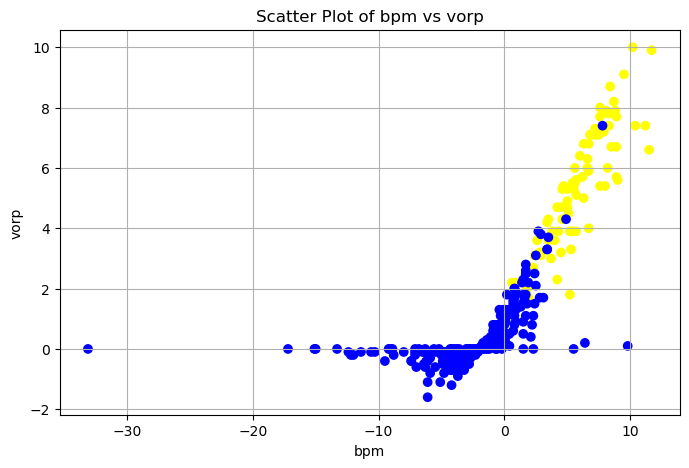

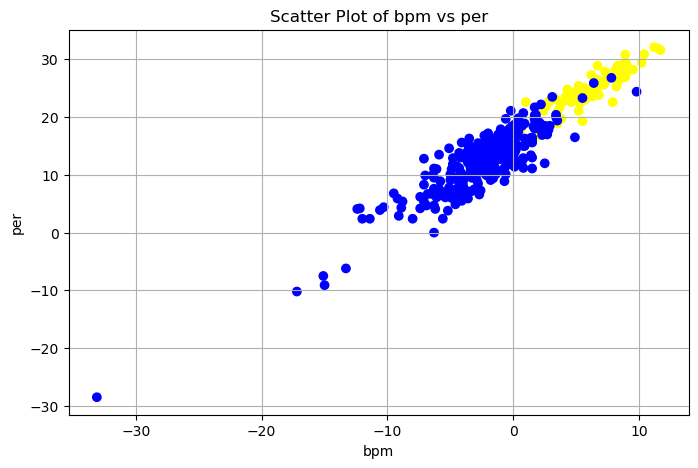

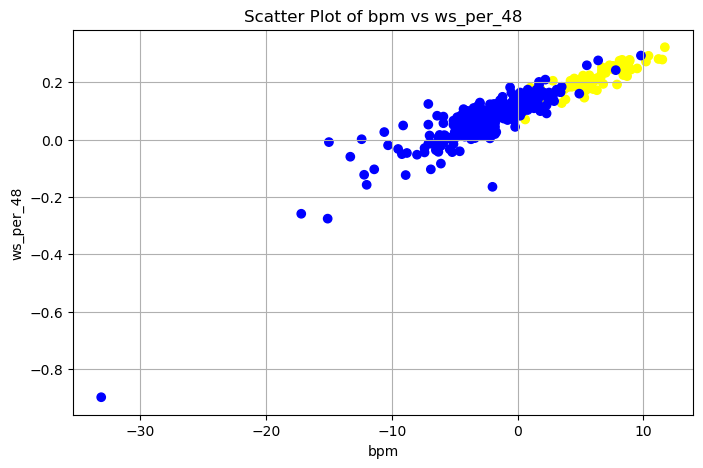

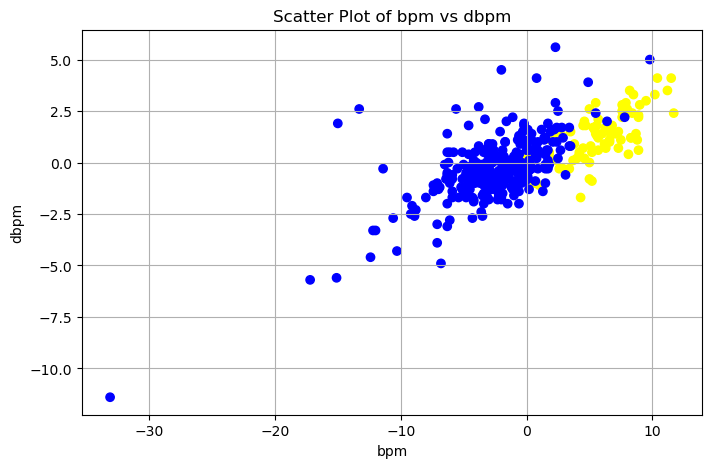

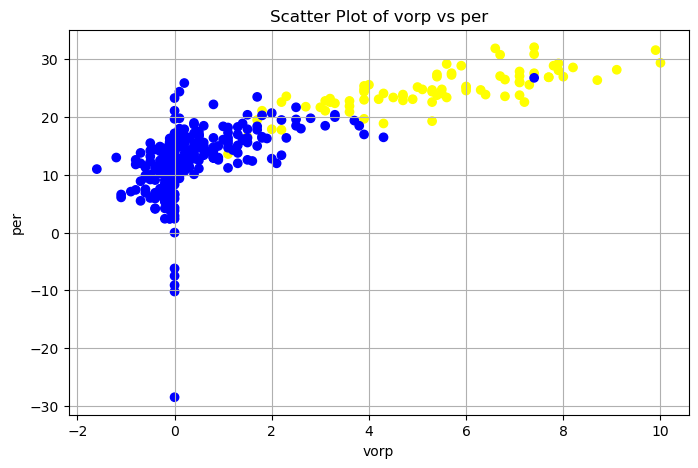

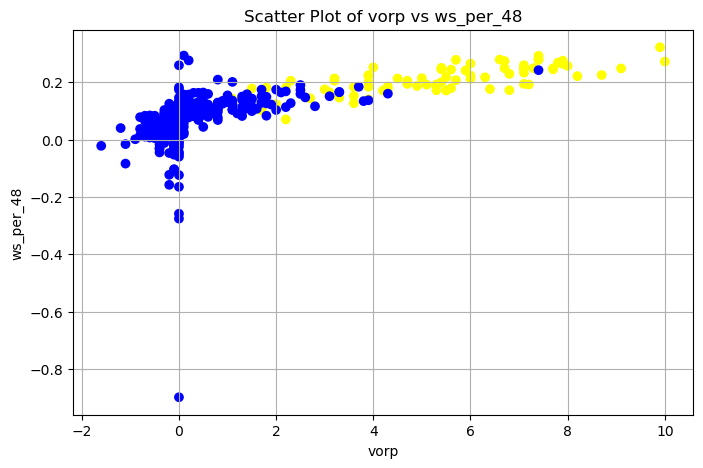

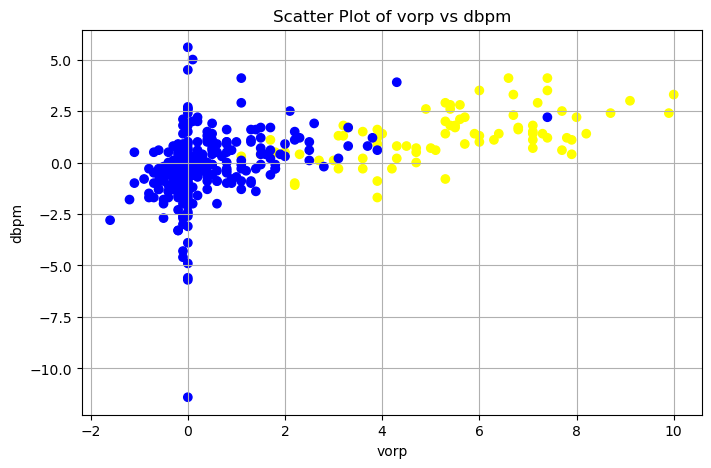

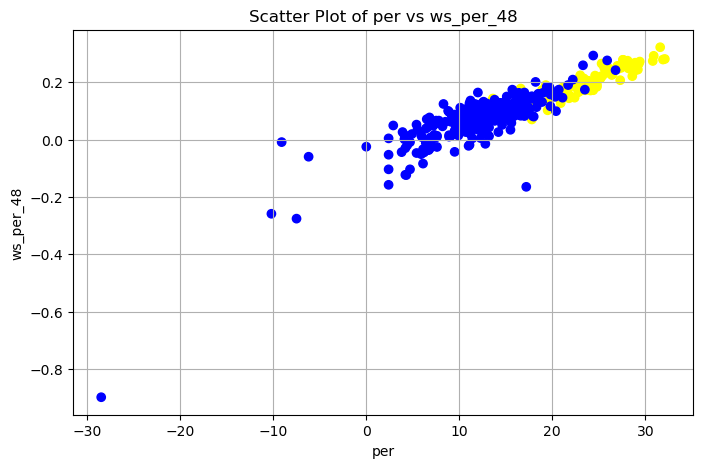

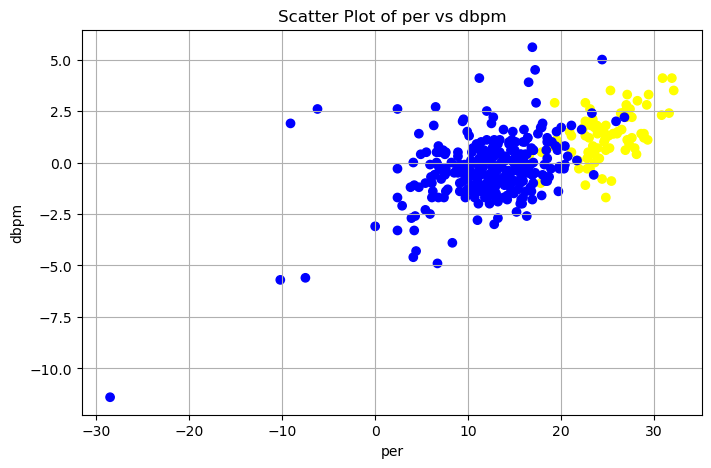

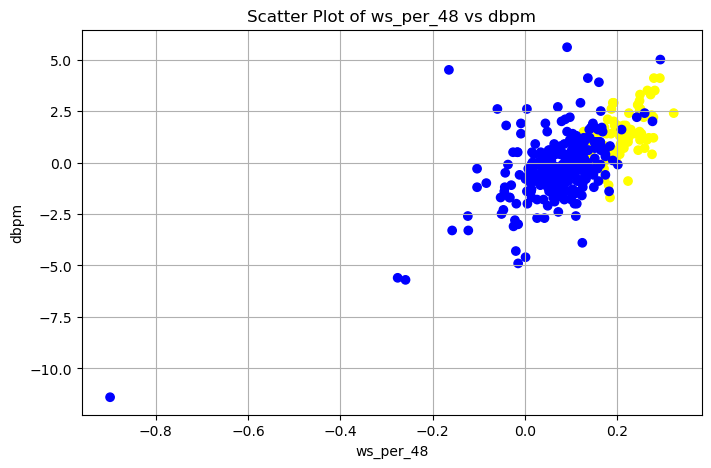

In [19]:
from itertools import combinations

from matplotlib import pyplot as plt


metrics = ['bpm', 'vorp', 'per', 'ws_per_48', 'dbpm']
metric_pairs = list(combinations(metrics, 2))

#azul = bagre
colors = ['yellow' if x > 0 else 'blue' for x in bagres_e_craques['award_share']]

# Loop through each pair of metrics and create a scatter plot
for metric1, metric2 in metric_pairs:
    plt.figure(figsize=(8, 5))  # Optional: specify figure size
    plt.scatter(bagres_e_craques[metric1], bagres_e_craques[metric2], color=colors)
    plt.xlabel(metric1)
    plt.ylabel(metric2)
    plt.title(f'Scatter Plot of {metric1} vs {metric2}')
    plt.grid(True)
    plt.show()

### K-Means

In [20]:
# List of metrics to use for clustering
from sklearn.cluster import KMeans


metrics = ['bpm', 'vorp', 'per', 'ws_per_48', 'dbpm']

# Create all combinations of metrics for clustering (pairs in this case)
metric_pairs = list(combinations(metrics, 2))

# Loop through each pair of metrics and perform clustering
for metric1, metric2 in metric_pairs:
    print(f'Clustering on: {metric1} and {metric2}')
    
    features = bagres_e_craques[[metric1, metric2]]
    
    X = features.values
    
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(X)
    
    labels = kmeans.predict(X)
    bagres_e_craques['cluster'] = labels
    
    df = bagres_e_craques.copy()
    
    # Calculate 'expected_cluster' based on the condition
    df['expected_cluster'] = (df['award_share'] == 0).astype(int)
    
    # Compare 'expected_cluster' with 'cluster' to determine correct predictions
    df['correct_prediction'] = (df['cluster'] == df['expected_cluster']).astype(int)
    
    # Calculate accuracy
    accuracy = df['correct_prediction'].mean()
    if accuracy > 0.4:
        print(f'Accuracy for {metric1} vs {metric2}: {accuracy * 100:.2f}%\n')
    else:
        accuracy  = 1 - accuracy
        print(f'Accuracy for {metric1} vs {metric2}: {accuracy * 100:.2f}%\n')

Clustering on: bpm and vorp
Accuracy for bpm vs vorp: 91.56%

Clustering on: bpm and per
Accuracy for bpm vs per: 89.71%

Clustering on: bpm and ws_per_48
Accuracy for bpm vs ws_per_48: 89.18%

Clustering on: bpm and dbpm
Accuracy for bpm vs dbpm: 86.02%

Clustering on: vorp and per
Accuracy for vorp vs per: 90.50%

Clustering on: vorp and ws_per_48
Accuracy for vorp vs ws_per_48: 95.51%

Clustering on: vorp and dbpm
Accuracy for vorp vs dbpm: 94.99%

Clustering on: per and ws_per_48
Accuracy for per vs ws_per_48: 87.07%

Clustering on: per and dbpm
Accuracy for per vs dbpm: 89.18%

Clustering on: ws_per_48 and dbpm
Accuracy for ws_per_48 vs dbpm: 70.18%



### CMeans

In [21]:
from skfuzzy.cluster import cmeans, cmeans_predict
# Loop por cada par de métricas e realizar o clustering
for metric1, metric2 in metric_pairs:
    print(f'Clustering on: {metric1} and {metric2}')
    
    features = bagres_e_craques[[metric1, metric2]]
    X = features.values.T  # Transpor para a forma esperada pelo cmeans
    
    # Realizar o clustering com cmeans
    cntr, u, u0, d, jm, p, fpc = cmeans(data=X, c=2, m=2, error=0.005, maxiter=1000, init=None)
    
    # Prever os clusters
    u, u0, d, jm, p, fpc = cmeans_predict(X, cntr, m=2, error=0.005, maxiter=1000)
    labels = np.argmax(u, axis=0)
    
    # Adicionar os rótulos de cluster ao DataFrame
    bagres_e_craques['cluster'] = labels
    
    df = bagres_e_craques.copy()
    
    # Calcular 'expected_cluster' baseado na condição
    df['expected_cluster'] = (df['award_share'] == 0).astype(int)
    
    # Comparar 'expected_cluster' com 'cluster' para determinar previsões corretas
    df['correct_prediction'] = (df['cluster'] == df['expected_cluster']).astype(int)
    
    # Calcular a acurácia
    accuracy = df['correct_prediction'].mean()
    if accuracy > 0.4:
        print(f'Accuracy for {metric1} vs {metric2}: {accuracy * 100:.2f}%\n')
    else:
        accuracy  = 1 - accuracy
        print(f'Accuracy for {metric1} vs {metric2}: {accuracy * 100:.2f}%\n')


Clustering on: bpm and vorp
Accuracy for bpm vs vorp: 91.56%

Clustering on: bpm and per
Accuracy for bpm vs per: 88.92%

Clustering on: bpm and ws_per_48
Accuracy for bpm vs ws_per_48: 86.28%

Clustering on: bpm and dbpm
Accuracy for bpm vs dbpm: 85.75%

Clustering on: vorp and per
Accuracy for vorp vs per: 89.71%

Clustering on: vorp and ws_per_48
Accuracy for vorp vs ws_per_48: 95.25%

Clustering on: vorp and dbpm
Accuracy for vorp vs dbpm: 94.72%

Clustering on: per and ws_per_48
Accuracy for per vs ws_per_48: 86.54%

Clustering on: per and dbpm
Accuracy for per vs dbpm: 86.81%

Clustering on: ws_per_48 and dbpm
Accuracy for ws_per_48 vs dbpm: 70.18%



# Análise com SGs

In [22]:
candidatos_SG = nba_SG[nba_SG["award_share"] > 0.001]

correlations_SG = candidatos_SG.corr(numeric_only=True)['award_share'].sort_values(ascending=False)
print(correlations_SG.head(12))

award_share    1.000000
ws             0.698534
vorp           0.683708
ws_per_48      0.661866
per            0.645268
bpm            0.640335
obpm           0.635697
ows            0.625291
fg_per_g       0.596177
pts_per_g      0.595941
dws            0.536840
fg2_per_g      0.499387
Name: award_share, dtype: float64


In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Preparing the data
X = candidatos_SG.drop('award_share', axis=1)
y = candidatos_SG['award_share']

# Convert categorical columns to numeric using Label Encoding or One-Hot Encoding
# Here using Label Encoding as an example
label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creating and fitting the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importance
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display the feature importances
print(importances.head(12))

ws                 0.411874
vorp               0.226181
ws_per_48          0.055843
obpm               0.022806
mov_adj            0.020070
dws                0.017726
mov                0.016549
win_loss_pct       0.016076
fga_per_g          0.015174
bpm                0.014403
per                0.013372
fta_per_fga_pct    0.010643
dtype: float64


**ws**                 

**vorp**               

**ws_per_48**         

**obpm**             

**mov_adj**           

In [24]:
#filtrando data
nba_SG = nba_new[nba_new["pos"] == "SG"]
nba_SG = nba_SG[nba_SG["season"] >= 1995]

#0.001 -> cara que recebeu só um voto, provavelmente
candidatos_SG = nba_SG[nba_SG["award_share"] > 0.001]

candidatos_SG = candidatos_SG[["player", "ws", "vorp", "ws_per_48", "obpm", "mov_adj", "award_share"]]

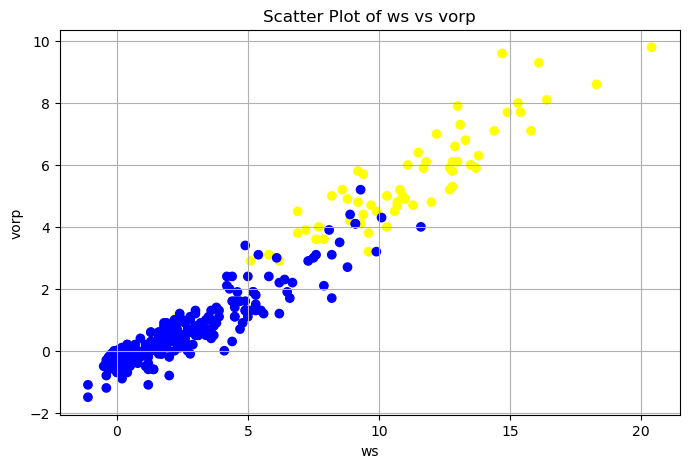

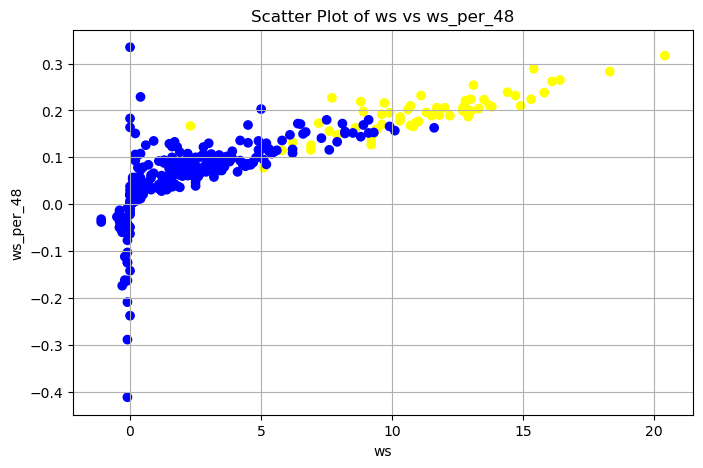

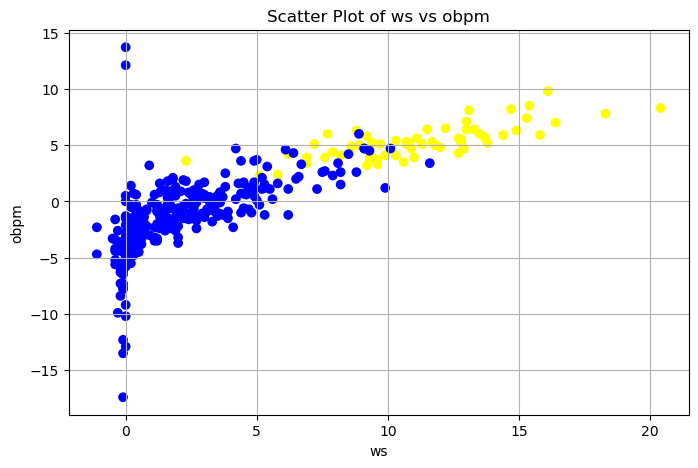

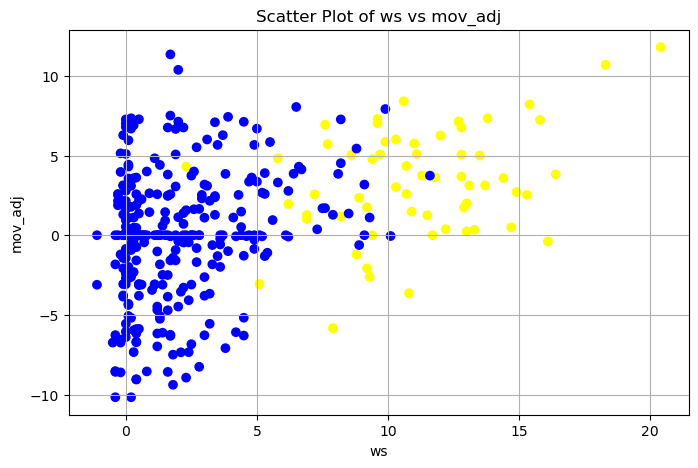

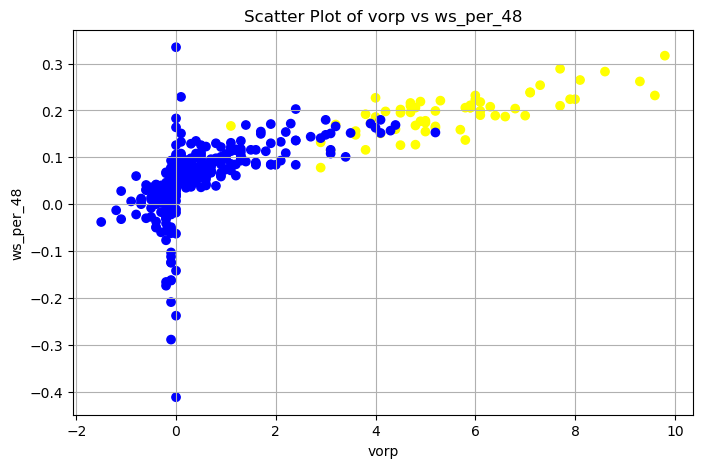

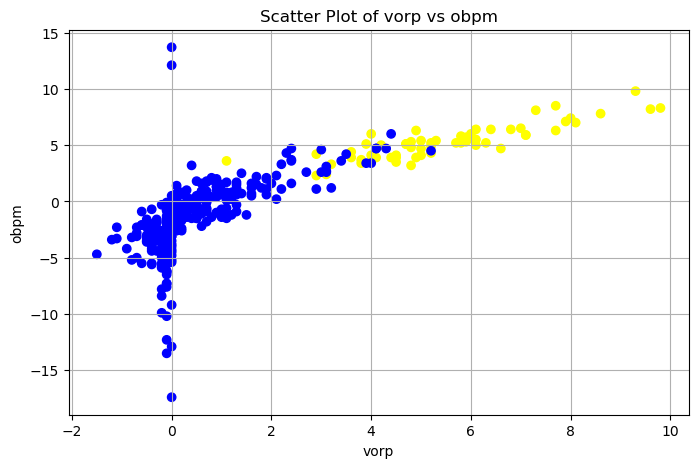

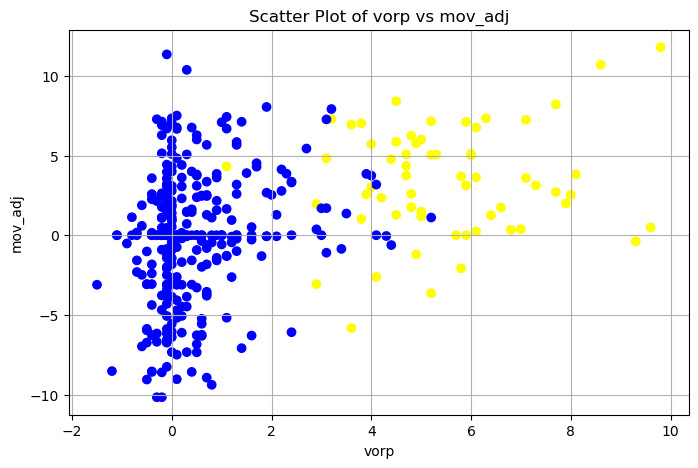

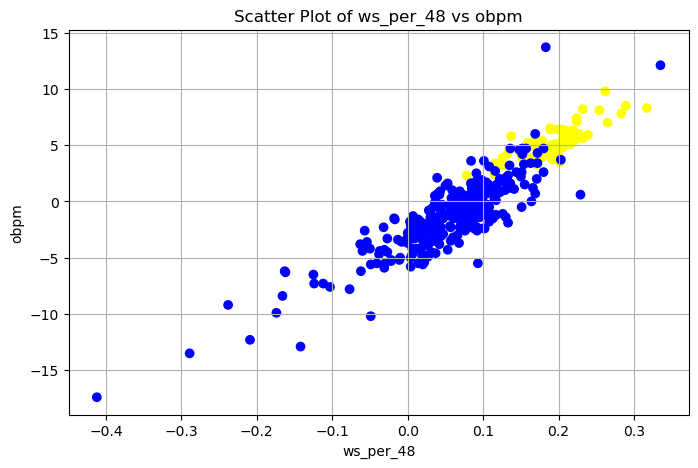

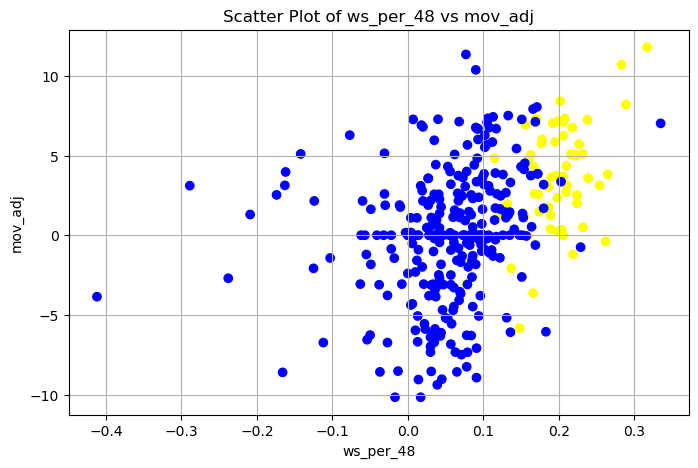

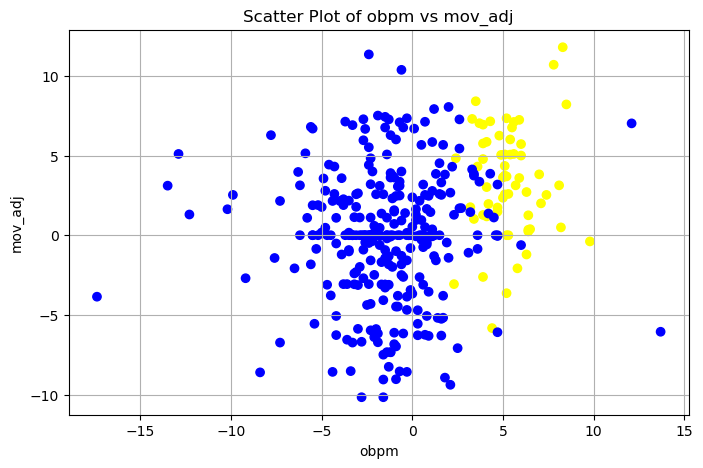

In [25]:
bagres_SG = nba_SG[nba_SG["award_share"] <= 0]
#amostra de 300 bagres
bagresSG_amostra = bagres_SG.sample(300)
bagresSG_amostra = bagresSG_amostra[["player", "ws", "vorp", "ws_per_48", "obpm", "mov_adj", "award_share"]]

bagres_e_craques_SG = pd.concat([candidatos_SG, bagresSG_amostra], ignore_index=True)

metrics = ["ws", "vorp", "ws_per_48", "obpm", "mov_adj"]
metric_pairs = list(combinations(metrics, 2))

#azul = bagre
colors = ['yellow' if x > 0 else 'blue' for x in bagres_e_craques_SG['award_share']]

# Loop through each pair of metrics and create a scatter plot
for metric1, metric2 in metric_pairs:
    plt.figure(figsize=(8, 5))  # Optional: specify figure size
    plt.scatter(bagres_e_craques_SG[metric1], bagres_e_craques_SG[metric2], color=colors)
    plt.xlabel(metric1)
    plt.ylabel(metric2)
    plt.title(f'Scatter Plot of {metric1} vs {metric2}')
    plt.grid(True)
    plt.show()

### KMeans

In [26]:
# List of metrics to use for clustering
metrics = ["ws", "vorp", "ws_per_48", "obpm", "mov_adj"]

# Create all combinations of metrics for clustering (pairs in this case)
metric_pairs = list(combinations(metrics, 2))

# Loop through each pair of metrics and perform clustering
for metric1, metric2 in metric_pairs:
    print(f'Clustering on: {metric1} and {metric2}')
    
    features = bagres_e_craques_SG[[metric1, metric2]]
    
    X = features.values
    
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(X)
    
    labels = kmeans.predict(X)
    bagres_e_craques_SG['cluster'] = labels
    
    df = bagres_e_craques_SG.copy()
    
    # Calculate 'expected_cluster' based on the condition
    df['expected_cluster'] = (df['award_share'] == 0).astype(int)
    
    # Compare 'expected_cluster' with 'cluster' to determine correct predictions
    df['correct_prediction'] = (df['cluster'] == df['expected_cluster']).astype(int)
    
    # Calculate accuracy
    accuracy = df['correct_prediction'].mean()
    if accuracy > 0.4:
        print(f'Accuracy for {metric1} vs {metric2}: {accuracy * 100:.2f}%\n')
    else:
        accuracy  = 1 - accuracy
        print(f'Accuracy for {metric1} vs {metric2}: {accuracy * 100:.2f}%\n')

Clustering on: ws and vorp
Accuracy for ws vs vorp: 94.18%

Clustering on: ws and ws_per_48
Accuracy for ws vs ws_per_48: 92.80%

Clustering on: ws and obpm
Accuracy for ws vs obpm: 91.14%

Clustering on: ws and mov_adj
Accuracy for ws vs mov_adj: 86.43%

Clustering on: vorp and ws_per_48
Accuracy for vorp vs ws_per_48: 95.29%

Clustering on: vorp and obpm
Accuracy for vorp vs obpm: 91.69%

Clustering on: vorp and mov_adj
Accuracy for vorp vs mov_adj: 56.23%

Clustering on: ws_per_48 and obpm
Accuracy for ws_per_48 vs obpm: 77.01%

Clustering on: ws_per_48 and mov_adj
Accuracy for ws_per_48 vs mov_adj: 57.62%

Clustering on: obpm and mov_adj
Accuracy for obpm vs mov_adj: 76.18%



### CMeans

In [27]:
from skfuzzy.cluster import cmeans, cmeans_predict
# Loop por cada par de métricas e realizar o clustering
for metric1, metric2 in metric_pairs:
    print(f'Clustering on: {metric1} and {metric2}')
    
    features = bagres_e_craques_SG[[metric1, metric2]]
    X = features.values.T  # Transpor para a forma esperada pelo cmeans
    
    # Realizar o clustering com cmeans
    cntr, u, u0, d, jm, p, fpc = cmeans(data=X, c=2, m=2, error=0.005, maxiter=1000, init=None)
    
    # Prever os clusters
    u, u0, d, jm, p, fpc = cmeans_predict(X, cntr, m=2, error=0.005, maxiter=1000)
    labels = np.argmax(u, axis=0)
    
    # Adicionar os rótulos de cluster ao DataFrame
    bagres_e_craques_SG['cluster'] = labels
    
    df = bagres_e_craques_SG.copy()
    
    # Calcular 'expected_cluster' baseado na condição
    df['expected_cluster'] = (df['award_share'] == 0).astype(int)
    
    # Comparar 'expected_cluster' com 'cluster' para determinar previsões corretas
    df['correct_prediction'] = (df['cluster'] == df['expected_cluster']).astype(int)
    
    # Calcular a acurácia
    accuracy = df['correct_prediction'].mean()
    if accuracy > 0.4:
        print(f'Accuracy for {metric1} vs {metric2}: {accuracy * 100:.2f}%\n')
    else:
        accuracy  = 1 - accuracy
        print(f'Accuracy for {metric1} vs {metric2}: {accuracy * 100:.2f}%\n')

Clustering on: ws and vorp
Accuracy for ws vs vorp: 93.35%

Clustering on: ws and ws_per_48
Accuracy for ws vs ws_per_48: 92.80%

Clustering on: ws and obpm
Accuracy for ws vs obpm: 91.14%

Clustering on: ws and mov_adj
Accuracy for ws vs mov_adj: 85.32%

Clustering on: vorp and ws_per_48
Accuracy for vorp vs ws_per_48: 95.29%

Clustering on: vorp and obpm
Accuracy for vorp vs obpm: 90.86%

Clustering on: vorp and mov_adj
Accuracy for vorp vs mov_adj: 64.54%

Clustering on: ws_per_48 and obpm
Accuracy for ws_per_48 vs obpm: 80.89%

Clustering on: ws_per_48 and mov_adj
Accuracy for ws_per_48 vs mov_adj: 49.86%

Clustering on: obpm and mov_adj
Accuracy for obpm vs mov_adj: 72.58%



# Análise com Cs

In [28]:
candidatos_C = nba_C[nba_C["award_share"] > 0.001]

correlations_C = candidatos_C.corr(numeric_only=True)['award_share'].sort_values(ascending=False)
print(correlations_C.head(12))

award_share    1.000000
vorp           0.648451
ws             0.620120
ws_per_48      0.616820
bpm            0.615119
per            0.599663
obpm           0.586146
ows            0.534770
pts_per_g      0.499587
fg_per_g       0.461324
fg2_per_g      0.431374
fta_per_g      0.417220
Name: award_share, dtype: float64


In [29]:
# Dropping rows where any value is missing
candidatos_C.dropna(inplace=True)

# Or dropping columns with more than a certain percentage of missing values
threshold = 0.3  # Threshold to drop columns, e.g., if more than 30% values are missing
candidatos_C.dropna(axis=1, thresh=int(threshold * len(candidatos_C)), inplace=True)

# Replace inf/-inf with NaN (then you can fill NaN as shown above)
candidatos_C.replace([np.inf, -np.inf], np.nan, inplace=True)

candidatos_C = candidatos_C.apply(pd.to_numeric, errors='ignore')

C:\Users\l3598\AppData\Local\Temp\ipykernel_15232\766928907.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidatos_C.dropna(inplace=True)
C:\Users\l3598\AppData\Local\Temp\ipykernel_15232\766928907.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidatos_C.dropna(axis=1, thresh=int(threshold * len(candidatos_C)), inplace=True)
C:\Users\l3598\AppData\Local\Temp\ipykernel_15232\766928907.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Preparing the data
X = candidatos_C.drop('award_share', axis=1)
y = candidatos_C['award_share']

# Convert categorical columns to numeric using Label Encoding or One-Hot Encoding
# Here using Label Encoding as an example
label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creating and fitting the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importance
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display the feature importances
print(importances.head(12))

ws                 0.391752
vorp               0.140040
ows                0.044720
per                0.038804
obpm               0.037849
ws_per_48          0.033516
pts_per_g          0.022903
fg_per_g           0.020489
fta_per_fga_pct    0.018976
age                0.018898
fta_per_g          0.018120
tov_per_g          0.014336
dtype: float64


In [31]:
#filtrando data
nba_C = nba_new[nba_new["pos"] == "C"]
nba_C = nba_C[nba_C["season"] >= 1995]

#0.001 -> cara que recebeu só um voto, provavelmente
candidatos_C = nba_C[nba_C["award_share"] > 0.001]

candidatos_C = candidatos_C[["player", "ws", "bpm", "per", "ows", "obpm", "award_share"]]

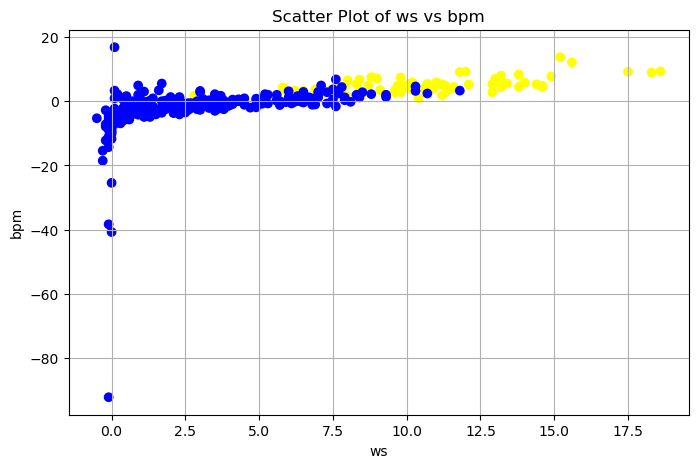

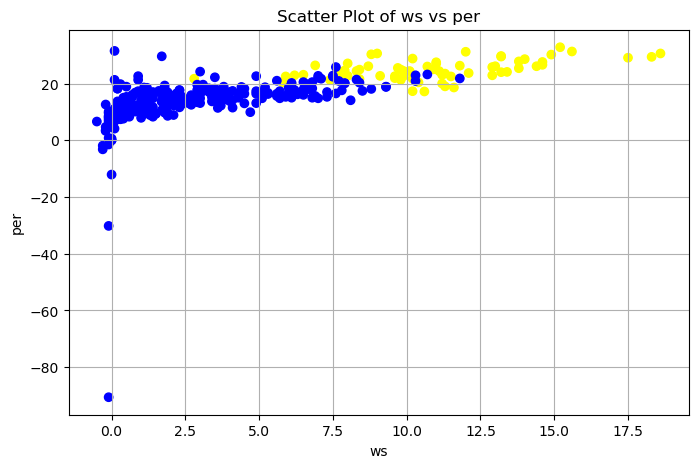

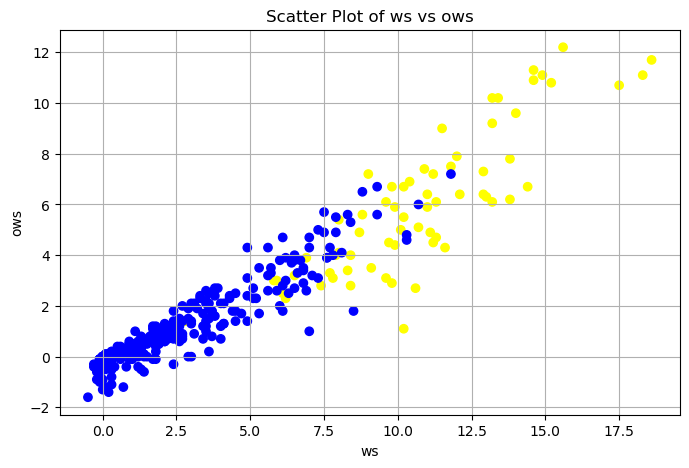

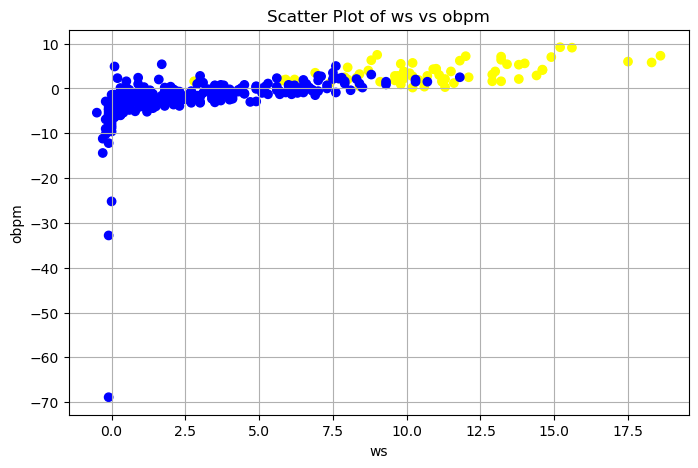

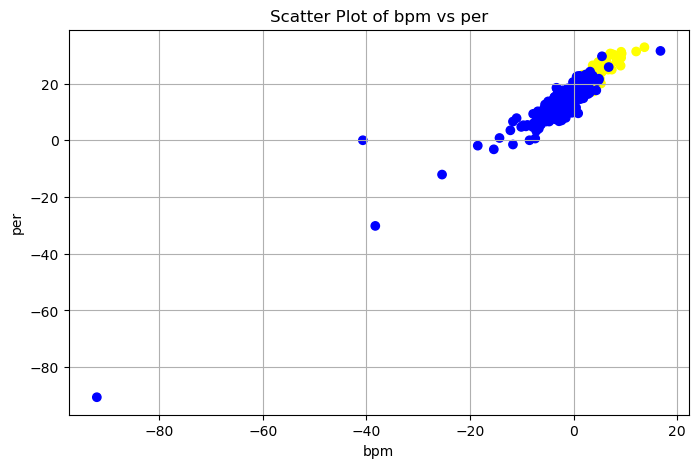

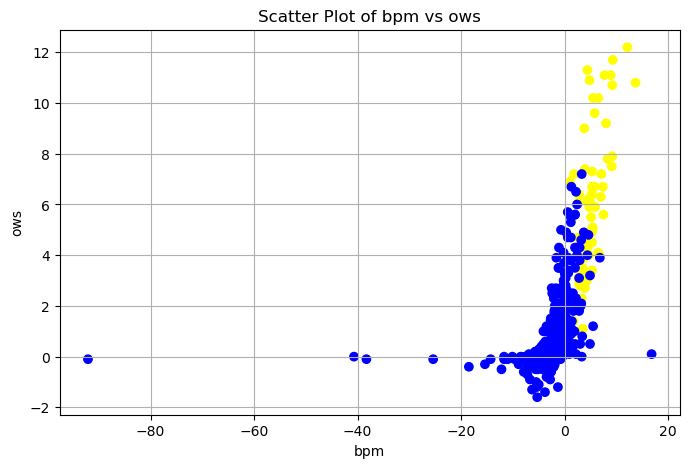

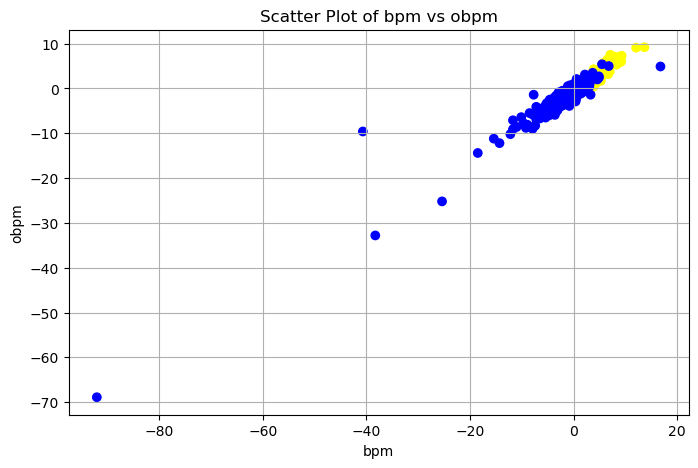

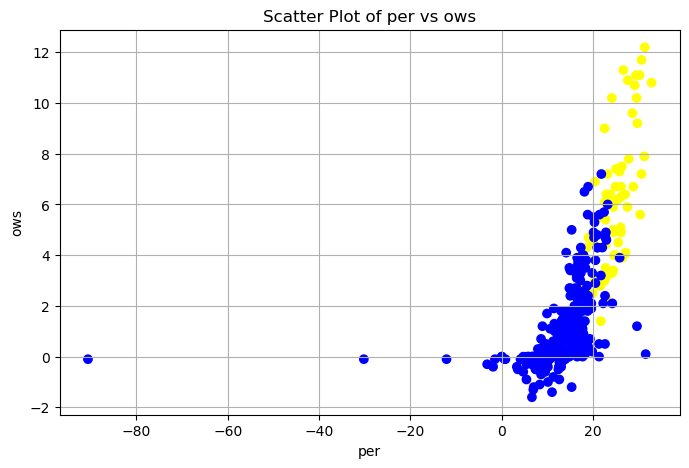

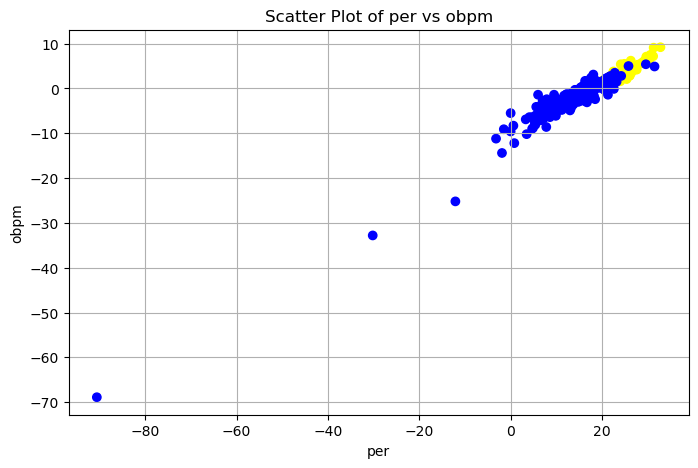

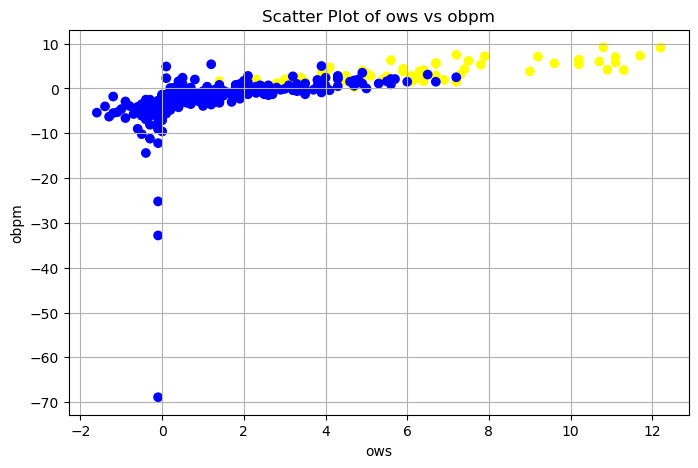

In [32]:
bagres_C = nba_C[nba_C["award_share"] <= 0]
#amostra de 300 bagres
bagresC_amostra = bagres_C.sample(300)
bagresC_amostra = bagresC_amostra[["player", "ws", "bpm", "per", "ows", "obpm", "award_share"]]

bagres_e_craques_C = pd.concat([candidatos_C, bagresC_amostra], ignore_index=True)

metrics = ["ws", "bpm", "per", "ows", "obpm"]
metric_pairs = list(combinations(metrics, 2))

#azul = bagre
colors = ['yellow' if x > 0 else 'blue' for x in bagres_e_craques_C['award_share']]

# Loop through each pair of metrics and create a scatter plot
for metric1, metric2 in metric_pairs:
    plt.figure(figsize=(8, 5))  # Optional: specify figure size
    plt.scatter(bagres_e_craques_C[metric1], bagres_e_craques_C[metric2], color=colors)
    plt.xlabel(metric1)
    plt.ylabel(metric2)
    plt.title(f'Scatter Plot of {metric1} vs {metric2}')
    plt.grid(True)
    plt.show()

### KMeans

In [33]:
# List of metrics to use for clustering
metrics = ["ws", "bpm", "per", "ows", "obpm"]

# Create all combinations of metrics for clustering (pairs in this case)
metric_pairs = list(combinations(metrics, 2))

# Loop through each pair of metrics and perform clustering
for metric1, metric2 in metric_pairs:
    print(f'Clustering on: {metric1} and {metric2}')
    
    features = bagres_e_craques_C[[metric1, metric2]]
    
    X = features.values
    
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(X)
    
    labels = kmeans.predict(X)
    bagres_e_craques_C['cluster'] = labels
    
    df = bagres_e_craques_C.copy()
    
    # Calculate 'expected_cluster' based on the condition
    df['expected_cluster'] = (df['award_share'] == 0).astype(int)
    
    # Compare 'expected_cluster' with 'cluster' to determine correct predictions
    df['correct_prediction'] = (df['cluster'] == df['expected_cluster']).astype(int)
    
    # Calculate accuracy
    accuracy = df['correct_prediction'].mean()
    if accuracy > 0.4:
        print(f'Accuracy for {metric1} vs {metric2}: {accuracy * 100:.2f}%\n')
    else:
        accuracy  = 1 - accuracy
        print(f'Accuracy for {metric1} vs {metric2}: {accuracy * 100:.2f}%\n')

Clustering on: ws and bpm
Accuracy for ws vs bpm: 81.69%

Clustering on: ws and per
Accuracy for ws vs per: 86.07%

Clustering on: ws and ows
Accuracy for ws vs ows: 85.52%

Clustering on: ws and obpm
Accuracy for ws vs obpm: 84.43%

Clustering on: bpm and per
Accuracy for bpm vs per: 50.00%

Clustering on: bpm and ows
Accuracy for bpm vs ows: 81.69%

Clustering on: bpm and obpm
Accuracy for bpm vs obpm: 80.87%

Clustering on: per and ows
Accuracy for per vs ows: 67.21%

Clustering on: per and obpm
Accuracy for per vs obpm: 81.69%

Clustering on: ows and obpm
Accuracy for ows vs obpm: 78.96%



### CMeans

In [34]:
from skfuzzy.cluster import cmeans, cmeans_predict
# Loop por cada par de métricas e realizar o clustering
for metric1, metric2 in metric_pairs:
    print(f'Clustering on: {metric1} and {metric2}')
    
    features = bagres_e_craques_C[[metric1, metric2]]
    X = features.values.T  # Transpor para a forma esperada pelo cmeans
    
    # Realizar o clustering com cmeans
    cntr, u, u0, d, jm, p, fpc = cmeans(data=X, c=2, m=2, error=0.005, maxiter=1000, init=None)
    
    # Prever os clusters
    u, u0, d, jm, p, fpc = cmeans_predict(X, cntr, m=2, error=0.005, maxiter=1000)
    labels = np.argmax(u, axis=0)
    
    # Adicionar os rótulos de cluster ao DataFrame
    bagres_e_craques_C['cluster'] = labels
    
    df = bagres_e_craques_C.copy()
    
    # Calcular 'expected_cluster' baseado na condição
    df['expected_cluster'] = (df['award_share'] == 0).astype(int)
    
    # Comparar 'expected_cluster' com 'cluster' para determinar previsões corretas
    df['correct_prediction'] = (df['cluster'] == df['expected_cluster']).astype(int)
    
    # Calcular a acurácia
    accuracy = df['correct_prediction'].mean()
    if accuracy > 0.4:
        print(f'Accuracy for {metric1} vs {metric2}: {accuracy * 100:.2f}%\n')
    else:
        accuracy  = 1 - accuracy
        print(f'Accuracy for {metric1} vs {metric2}: {accuracy * 100:.2f}%\n')

Clustering on: ws and bpm
Accuracy for ws vs bpm: 82.79%

Clustering on: ws and per
Accuracy for ws vs per: 80.33%

Clustering on: ws and ows
Accuracy for ws vs ows: 86.61%

Clustering on: ws and obpm
Accuracy for ws vs obpm: 84.43%

Clustering on: bpm and per
Accuracy for bpm vs per: 65.57%

Clustering on: bpm and ows
Accuracy for bpm vs ows: 75.41%

Clustering on: bpm and obpm
Accuracy for bpm vs obpm: 62.84%

Clustering on: per and ows
Accuracy for per vs ows: 71.31%

Clustering on: per and obpm
Accuracy for per vs obpm: 65.03%

Clustering on: ows and obpm
Accuracy for ows vs obpm: 78.42%



# Análises com PGs

In [35]:
candidatos_PG = nba_PG[nba_PG["award_share"] > 0.001]

correlations_PG = candidatos_PG.corr(numeric_only=True)['award_share'].sort_values(ascending=False)
print(correlations_PG.head(12))

award_share     1.000000
per             0.534867
bpm             0.525443
vorp            0.524878
obpm            0.521863
ws              0.479574
ws_per_48       0.471578
ows             0.446041
win_loss_pct    0.362132
ft_per_g        0.329736
pts_per_g       0.325862
trb_pct         0.324456
Name: award_share, dtype: float64


In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Preparing the data
X = candidatos_PG.drop('award_share', axis=1)
y = candidatos_PG['award_share']

# Convert categorical columns to numeric using Label Encoding or One-Hot Encoding
# Here using Label Encoding as an example
label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creating and fitting the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importance
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display the feature importances
print(importances.head(12))

ows             0.209398
bpm             0.133054
per             0.109716
obpm            0.073919
vorp            0.057294
win_loss_pct    0.033973
ws              0.033864
fg2_pct         0.020876
fg_per_g        0.020116
trb_pct         0.019003
dws             0.018332
ast_pct         0.016742
dtype: float64


In [37]:
#filtrando data
nba_PG = nba_new[nba_new["pos"] == "PG"]
nba_PG = nba_PG[nba_PG["season"] >= 1995]

#0.001 -> cara que recebeu só um voto, provavelmente
candidatos_PG = nba_PG[nba_PG["award_share"] > 0.001]

candidatos_PG = candidatos_PG[["player", "ows", "bpm", "per", "obpm", "vorp", "award_share"]]

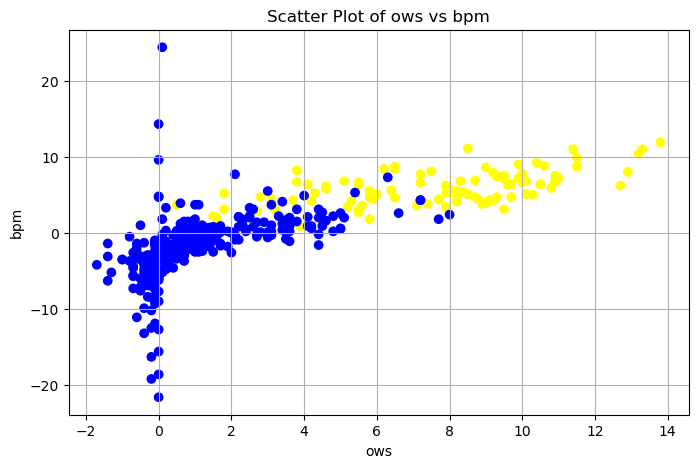

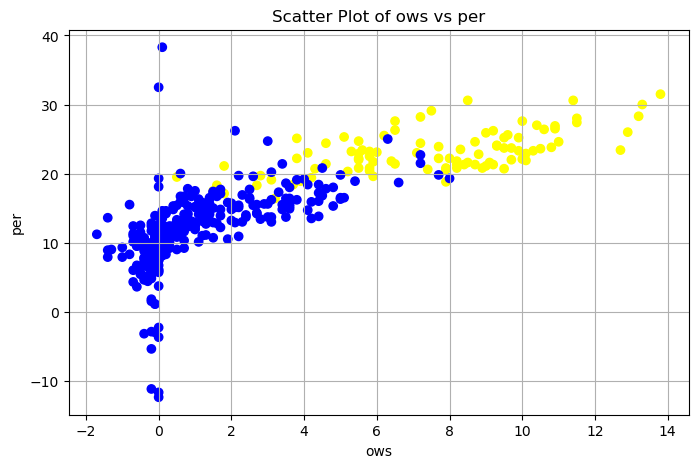

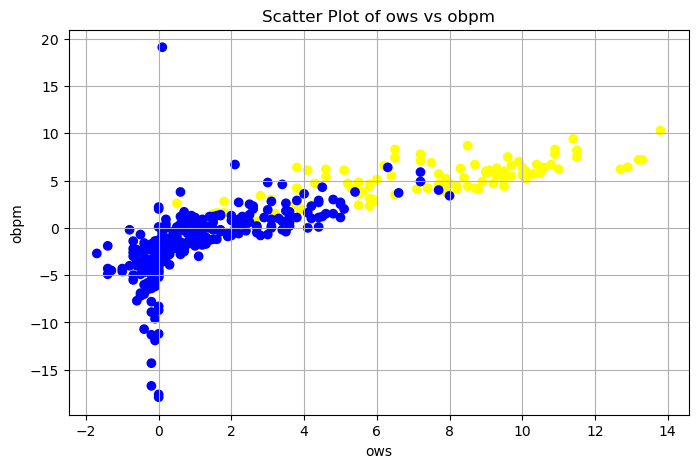

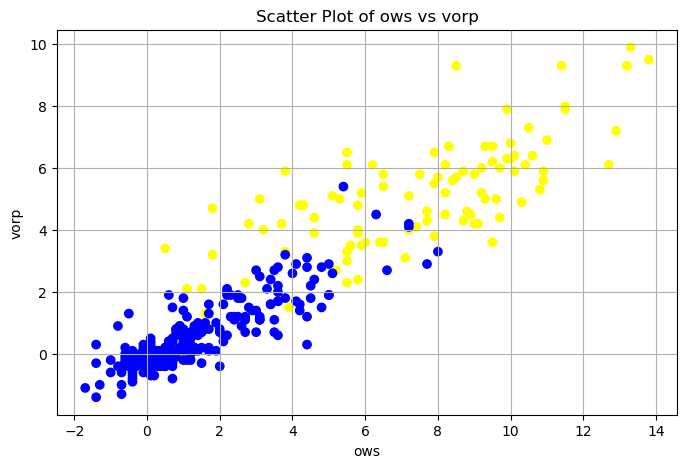

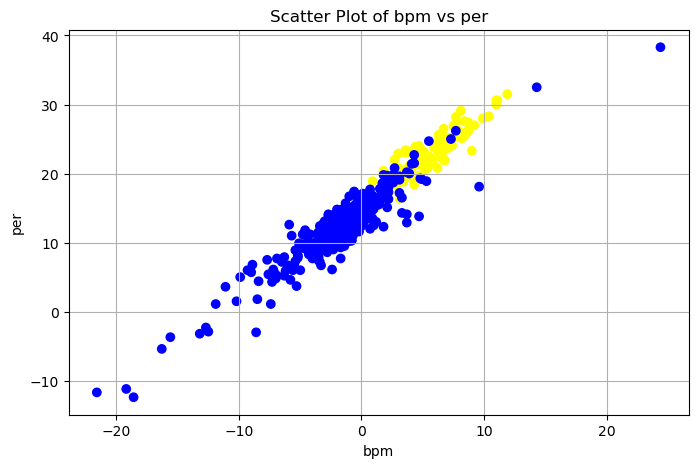

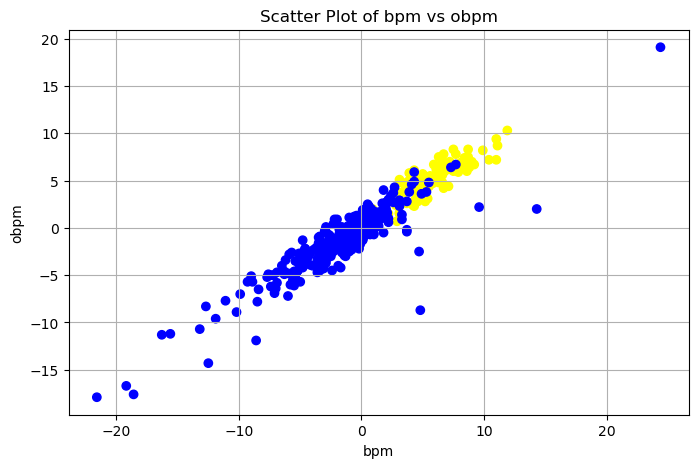

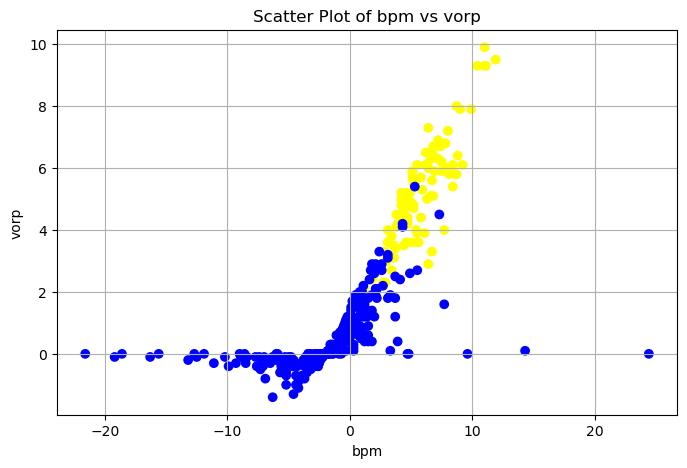

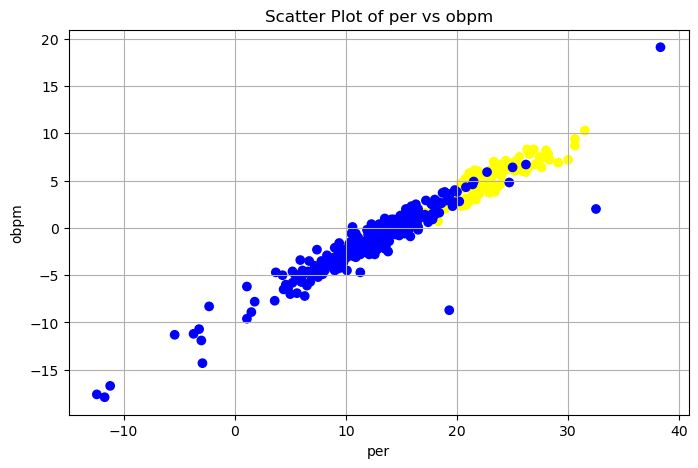

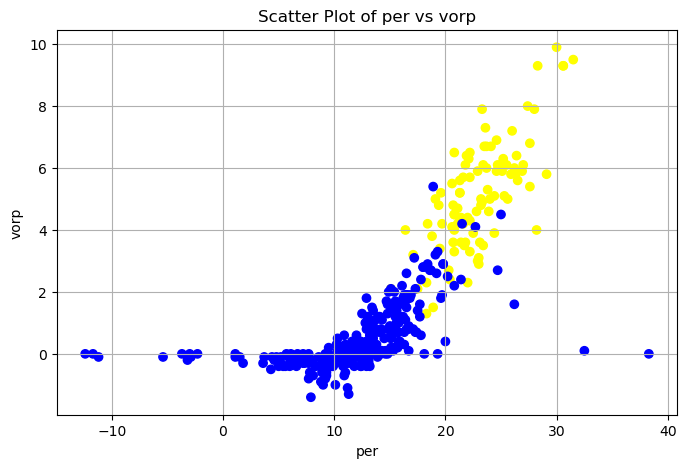

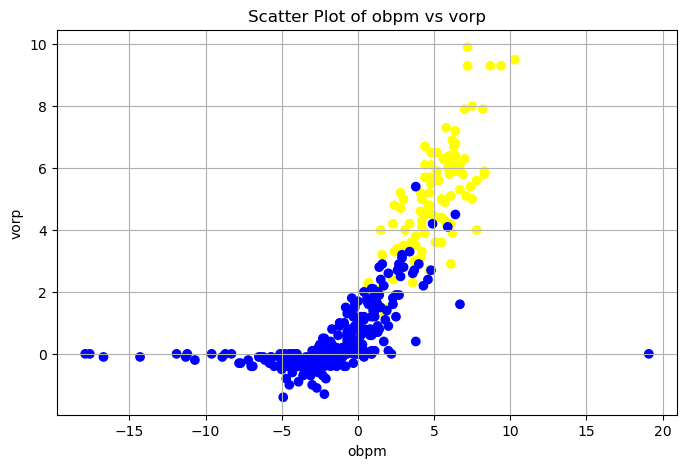

In [38]:
bagres_PG = nba_PG[nba_PG["award_share"] <= 0]
#amostra de 300 bagres
bagresPG_amostra = bagres_PG.sample(300)
bagresPG_amostra = bagresPG_amostra[["player", "ows", "bpm", "per", "obpm", "vorp", "award_share"]]

bagres_e_craques_PG = pd.concat([candidatos_PG, bagresPG_amostra], ignore_index=True)

metrics = ["ows", "bpm", "per", "obpm", "vorp"]
metric_pairs = list(combinations(metrics, 2))

#azul = bagre
colors = ['yellow' if x > 0 else 'blue' for x in bagres_e_craques_PG['award_share']]

# Loop through each pair of metrics and create a scatter plot
for metric1, metric2 in metric_pairs:
    plt.figure(figsize=(8, 5))  # Optional: specify figure size
    plt.scatter(bagres_e_craques_PG[metric1], bagres_e_craques_PG[metric2], color=colors)
    plt.xlabel(metric1)
    plt.ylabel(metric2)
    plt.title(f'Scatter Plot of {metric1} vs {metric2}')
    plt.grid(True)
    plt.show()

### KMeans

In [39]:
# List of metrics to use for clustering
metrics = ["ows", "bpm", "per", "obpm", "vorp"]

# Create all combinations of metrics for clustering (pairs in this case)
metric_pairs = list(combinations(metrics, 2))

# Loop through each pair of metrics and perform clustering
for metric1, metric2 in metric_pairs:
    print(f'Clustering on: {metric1} and {metric2}')
    
    features = bagres_e_craques_PG[[metric1, metric2]]
    
    X = features.values
    
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(X)
    
    labels = kmeans.predict(X)
    bagres_e_craques_PG['cluster'] = labels
    
    df = bagres_e_craques_PG.copy()
    
    # Calculate 'expected_cluster' based on the condition
    df['expected_cluster'] = (df['award_share'] == 0).astype(int)
    
    # Compare 'expected_cluster' with 'cluster' to determine correct predictions
    df['correct_prediction'] = (df['cluster'] == df['expected_cluster']).astype(int)
    
    # Calculate accuracy
    accuracy = df['correct_prediction'].mean()
    if accuracy > 0.4:
        print(f'Accuracy for {metric1} vs {metric2}: {accuracy * 100:.2f}%\n')
    else:
        accuracy  = 1 - accuracy
        print(f'Accuracy for {metric1} vs {metric2}: {accuracy * 100:.2f}%\n')

Clustering on: ows and bpm
Accuracy for ows vs bpm: 89.17%

Clustering on: ows and per
Accuracy for ows vs per: 90.43%

Clustering on: ows and obpm
Accuracy for ows vs obpm: 90.93%

Clustering on: ows and vorp
Accuracy for ows vs vorp: 93.20%

Clustering on: bpm and per
Accuracy for bpm vs per: 89.92%

Clustering on: bpm and obpm
Accuracy for bpm vs obpm: 82.87%

Clustering on: bpm and vorp
Accuracy for bpm vs vorp: 89.17%

Clustering on: per and obpm
Accuracy for per vs obpm: 84.38%

Clustering on: per and vorp
Accuracy for per vs vorp: 90.43%

Clustering on: obpm and vorp
Accuracy for obpm vs vorp: 91.18%



### CMeans

In [40]:
from skfuzzy.cluster import cmeans, cmeans_predict
# Loop por cada par de métricas e realizar o clustering
for metric1, metric2 in metric_pairs:
    print(f'Clustering on: {metric1} and {metric2}')
    
    features = bagres_e_craques_PG[[metric1, metric2]]
    X = features.values.T  # Transpor para a forma esperada pelo cmeans
    
    # Realizar o clustering com cmeans
    cntr, u, u0, d, jm, p, fpc = cmeans(data=X, c=2, m=2, error=0.005, maxiter=1000, init=None)
    
    # Prever os clusters
    u, u0, d, jm, p, fpc = cmeans_predict(X, cntr, m=2, error=0.005, maxiter=1000)
    labels = np.argmax(u, axis=0)
    
    # Adicionar os rótulos de cluster ao DataFrame
    bagres_e_craques_PG['cluster'] = labels
    
    df = bagres_e_craques_PG.copy()
    
    # Calcular 'expected_cluster' baseado na condição
    df['expected_cluster'] = (df['award_share'] == 0).astype(int)
    
    # Comparar 'expected_cluster' com 'cluster' para determinar previsões corretas
    df['correct_prediction'] = (df['cluster'] == df['expected_cluster']).astype(int)
    
    # Calcular a acurácia
    accuracy = df['correct_prediction'].mean()
    if accuracy > 0.4:
        print(f'Accuracy for {metric1} vs {metric2}: {accuracy * 100:.2f}%\n')
    else:
        accuracy  = 1 - accuracy
        print(f'Accuracy for {metric1} vs {metric2}: {accuracy * 100:.2f}%\n')

Clustering on: ows and bpm
Accuracy for ows vs bpm: 88.66%

Clustering on: ows and per
Accuracy for ows vs per: 90.18%

Clustering on: ows and obpm
Accuracy for ows vs obpm: 90.18%

Clustering on: ows and vorp
Accuracy for ows vs vorp: 93.20%

Clustering on: bpm and per
Accuracy for bpm vs per: 85.89%

Clustering on: bpm and obpm
Accuracy for bpm vs obpm: 84.63%

Clustering on: bpm and vorp
Accuracy for bpm vs vorp: 89.17%

Clustering on: per and obpm
Accuracy for per vs obpm: 85.14%

Clustering on: per and vorp
Accuracy for per vs vorp: 88.92%

Clustering on: obpm and vorp
Accuracy for obpm vs vorp: 91.18%



# Análises com SFs

In [41]:
candidatos_SF = nba_SF[nba_SF["award_share"] > 0.001]

correlations_SF = candidatos_SF.corr(numeric_only=True)['award_share'].sort_values(ascending=False)
print(correlations_SF.head(12))

award_share    1.000000
ws_per_48      0.733361
ws             0.731178
vorp           0.709471
per            0.706318
bpm            0.694448
obpm           0.675933
ows            0.631205
drb_per_g      0.473679
dws            0.464447
dbpm           0.462588
drb_pct        0.445957
Name: award_share, dtype: float64


In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Preparing the data
X = candidatos_SF.drop('award_share', axis=1)
y = candidatos_SF['award_share']

# Convert categorical columns to numeric using Label Encoding or One-Hot Encoding
# Here using Label Encoding as an example
label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creating and fitting the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importance
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display the feature importances
print(importances.head(12))

ws_per_48           0.495731
ws                  0.092724
per                 0.068409
vorp                0.047532
drb_pct             0.029927
fg3a_per_fga_pct    0.021223
ast_pct             0.020847
fg3a_per_g          0.014033
ast_per_g           0.013543
drb_per_g           0.013043
orb_per_g           0.013010
obpm                0.012426
dtype: float64


In [43]:
#filtrando data
nba_SF = nba_new[nba_new["pos"] == "SF"]
nba_SF = nba_SF[nba_SF["season"] >= 1995]

#0.001 -> cara que recebeu só um voto, provavelmente
candidatos_SF = nba_SF[nba_SF["award_share"] > 0.001]

candidatos_SF = candidatos_SF[["player", "ws_per_48", "per", "vorp", "drb_pct", "fg3a_per_fga_pct", "award_share"]]

In [44]:
bagres_SF = nba_SF[nba_SF["award_share"] <= 0]
#amostra de 300 bagres
bagresSF_amostra = bagres_SF.sample(300)
bagresSF_amostra = bagresSF_amostra[["player", "ws_per_48", "per", "vorp", "drb_pct", "fg3a_per_fga_pct", "award_share"]]

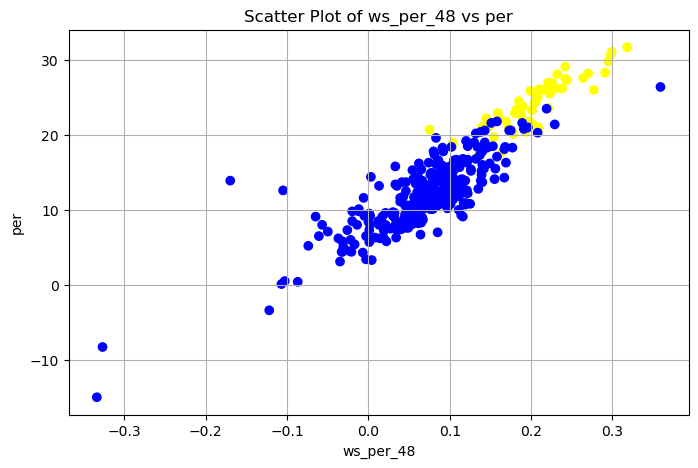

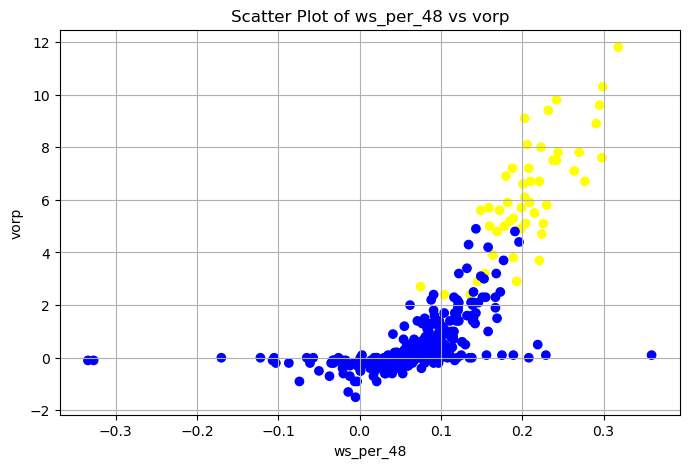

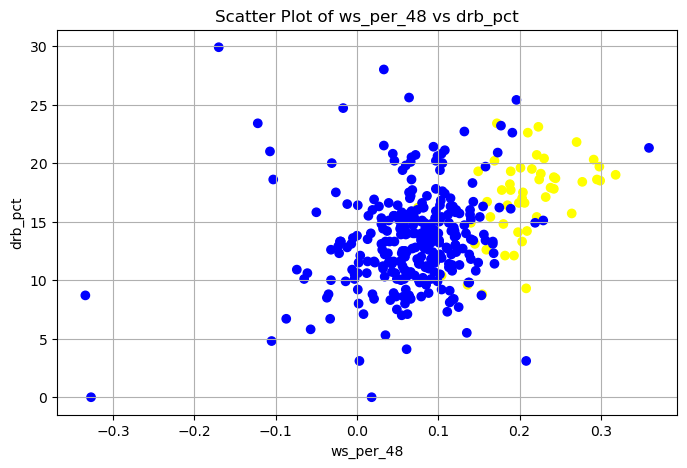

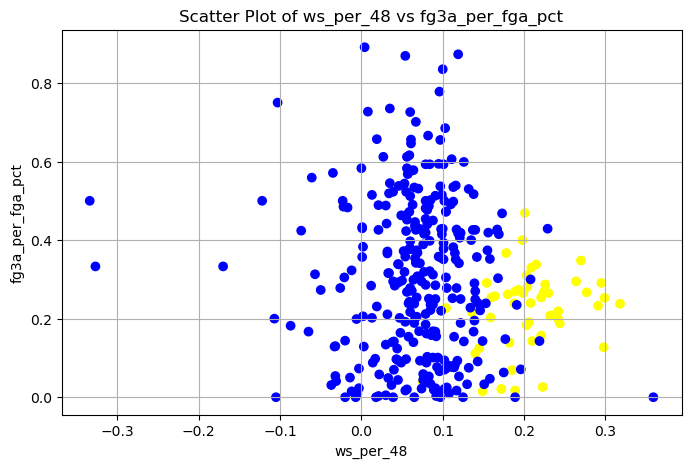

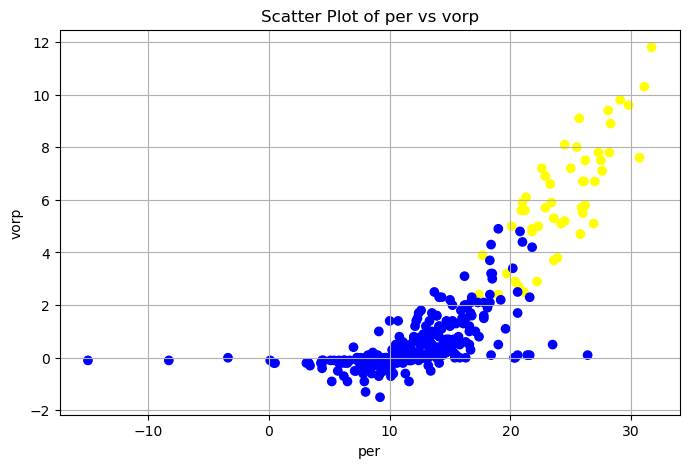

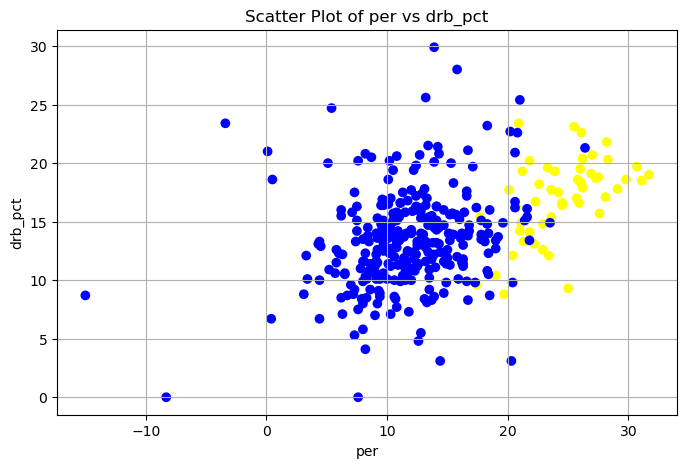

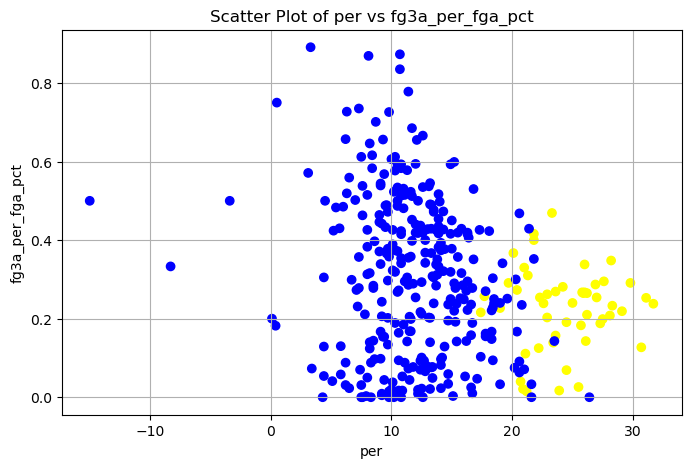

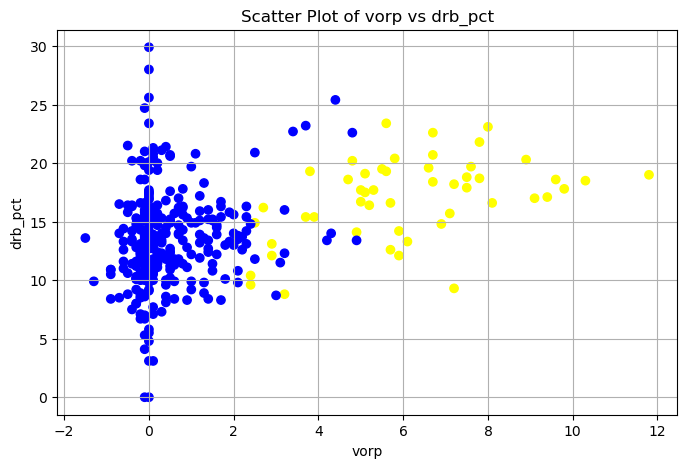

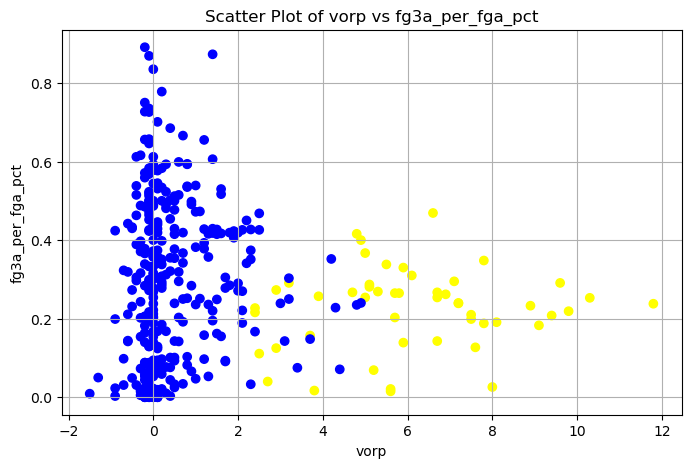

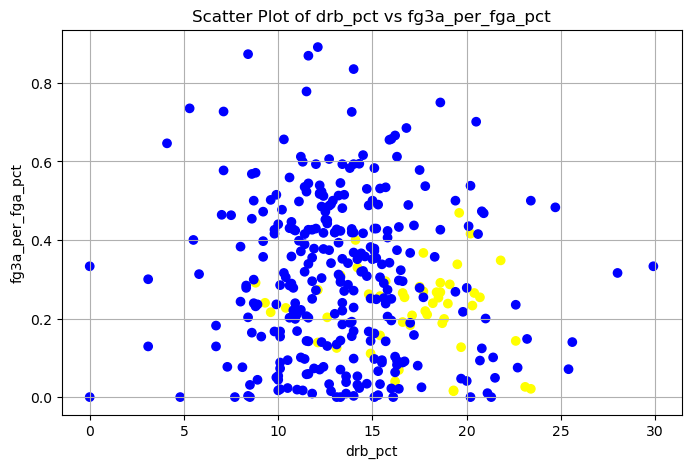

In [45]:
bagres_e_craques_SF = pd.concat([candidatos_SF, bagresSF_amostra], ignore_index=True)

metrics = ["ws_per_48", "per", "vorp", "drb_pct", "fg3a_per_fga_pct"]
metric_pairs = list(combinations(metrics, 2))

#azul = bagre
colors = ['yellow' if x > 0 else 'blue' for x in bagres_e_craques_SF['award_share']]

# Loop through each pair of metrics and create a scatter plot
for metric1, metric2 in metric_pairs:
    plt.figure(figsize=(8, 5))  # Optional: specify figure size
    plt.scatter(bagres_e_craques_SF[metric1], bagres_e_craques_SF[metric2], color=colors)
    plt.xlabel(metric1)
    plt.ylabel(metric2)
    plt.title(f'Scatter Plot of {metric1} vs {metric2}')
    plt.grid(True)
    plt.show()

### KMeans

In [46]:
# List of metrics to use for clustering
metrics = ["ws_per_48", "per", "vorp", "drb_pct", "fg3a_per_fga_pct"]

# Create all combinations of metrics for clustering (pairs in this case)
metric_pairs = list(combinations(metrics, 2))

# Loop through each pair of metrics and perform clustering
for metric1, metric2 in metric_pairs:
    print(f'Clustering on: {metric1} and {metric2}')
    
    features = bagres_e_craques_SF[[metric1, metric2]]
    
    X = features.values
    
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(X)
    
    labels = kmeans.predict(X)
    bagres_e_craques_SF['cluster'] = labels
    
    df = bagres_e_craques_SF.copy()
    
    # Calculate 'expected_cluster' based on the condition
    df['expected_cluster'] = (df['award_share'] == 0).astype(int)
    
    # Compare 'expected_cluster' with 'cluster' to determine correct predictions
    df['correct_prediction'] = (df['cluster'] == df['expected_cluster']).astype(int)
    
    # Calculate accuracy
    accuracy = df['correct_prediction'].mean()
    if accuracy > 0.4:
        print(f'Accuracy for {metric1} vs {metric2}: {accuracy * 100:.2f}%\n')
    else:
        accuracy  = 1 - accuracy
        print(f'Accuracy for {metric1} vs {metric2}: {accuracy * 100:.2f}%\n')

Clustering on: ws_per_48 and per
Accuracy for ws_per_48 vs per: 85.71%

Clustering on: ws_per_48 and vorp
Accuracy for ws_per_48 vs vorp: 96.29%

Clustering on: ws_per_48 and drb_pct
Accuracy for ws_per_48 vs drb_pct: 67.14%

Clustering on: ws_per_48 and fg3a_per_fga_pct
Accuracy for ws_per_48 vs fg3a_per_fga_pct: 53.43%

Clustering on: per and vorp
Accuracy for per vs vorp: 90.57%

Clustering on: per and drb_pct
Accuracy for per vs drb_pct: 86.29%

Clustering on: per and fg3a_per_fga_pct
Accuracy for per vs fg3a_per_fga_pct: 86.00%

Clustering on: vorp and drb_pct
Accuracy for vorp vs drb_pct: 68.29%

Clustering on: vorp and fg3a_per_fga_pct
Accuracy for vorp vs fg3a_per_fga_pct: 96.00%

Clustering on: drb_pct and fg3a_per_fga_pct
Accuracy for drb_pct vs fg3a_per_fga_pct: 66.29%



### CMeans

In [47]:
from skfuzzy.cluster import cmeans, cmeans_predict
# Loop por cada par de métricas e realizar o clustering
for metric1, metric2 in metric_pairs:
    print(f'Clustering on: {metric1} and {metric2}')
    
    features = bagres_e_craques_SF[[metric1, metric2]]
    X = features.values.T  # Transpor para a forma esperada pelo cmeans
    
    # Realizar o clustering com cmeans
    cntr, u, u0, d, jm, p, fpc = cmeans(data=X, c=2, m=2, error=0.005, maxiter=1000, init=None)
    
    # Prever os clusters
    u, u0, d, jm, p, fpc = cmeans_predict(X, cntr, m=2, error=0.005, maxiter=1000)
    labels = np.argmax(u, axis=0)
    
    # Adicionar os rótulos de cluster ao DataFrame
    bagres_e_craques_SF['cluster'] = labels
    
    df = bagres_e_craques_SF.copy()
    
    # Calcular 'expected_cluster' baseado na condição
    df['expected_cluster'] = (df['award_share'] == 0).astype(int)
    
    # Comparar 'expected_cluster' com 'cluster' para determinar previsões corretas
    df['correct_prediction'] = (df['cluster'] == df['expected_cluster']).astype(int)
    
    # Calcular a acurácia
    accuracy = df['correct_prediction'].mean()
    if accuracy > 0.4:
        print(f'Accuracy for {metric1} vs {metric2}: {accuracy * 100:.2f}%\n')
    else:
        accuracy  = 1 - accuracy
        print(f'Accuracy for {metric1} vs {metric2}: {accuracy * 100:.2f}%\n')

Clustering on: ws_per_48 and per
Accuracy for ws_per_48 vs per: 85.71%

Clustering on: ws_per_48 and vorp
Accuracy for ws_per_48 vs vorp: 96.00%

Clustering on: ws_per_48 and drb_pct
Accuracy for ws_per_48 vs drb_pct: 65.71%

Clustering on: ws_per_48 and fg3a_per_fga_pct
Accuracy for ws_per_48 vs fg3a_per_fga_pct: 54.57%

Clustering on: per and vorp
Accuracy for per vs vorp: 88.86%

Clustering on: per and drb_pct
Accuracy for per vs drb_pct: 83.71%

Clustering on: per and fg3a_per_fga_pct
Accuracy for per vs fg3a_per_fga_pct: 85.71%

Clustering on: vorp and drb_pct
Accuracy for vorp vs drb_pct: 68.57%

Clustering on: vorp and fg3a_per_fga_pct
Accuracy for vorp vs fg3a_per_fga_pct: 96.00%

Clustering on: drb_pct and fg3a_per_fga_pct
Accuracy for drb_pct vs fg3a_per_fga_pct: 65.71%



# GERAL

In [48]:
candidatos = nba_new[nba_new["award_share"] > 0.001]
correlations = candidatos.corr(numeric_only=True)['award_share'].sort_values(ascending=False)
print(correlations.head(12))

award_share     1.000000
vorp            0.619847
ws              0.612216
per             0.608795
ws_per_48       0.608265
bpm             0.604804
obpm            0.536607
ows             0.519139
pts_per_g       0.421927
fg_per_g        0.387272
win_loss_pct    0.369006
usg_pct         0.350347
Name: award_share, dtype: float64


In [49]:
# Dropping rows where any value is missing
candidatos.dropna(inplace=True)

# Or dropping columns with more than a certain percentage of missing values
threshold = 0.3  # Threshold to drop columns, e.g., if more than 30% values are missing
candidatos.dropna(axis=1, thresh=int(threshold * len(candidatos)), inplace=True)

# Replace inf/-inf with NaN (then you can fill NaN as shown above)
candidatos.replace([np.inf, -np.inf], np.nan, inplace=True)

candidatos = candidatos.apply(pd.to_numeric, errors='ignore')

C:\Users\l3598\AppData\Local\Temp\ipykernel_15232\1090000674.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidatos.dropna(inplace=True)
C:\Users\l3598\AppData\Local\Temp\ipykernel_15232\1090000674.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidatos.dropna(axis=1, thresh=int(threshold * len(candidatos)), inplace=True)
C:\Users\l3598\AppData\Local\Temp\ipykernel_15232\1090000674.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Preparing the data
X = candidatos.drop('award_share', axis=1)
y = candidatos['award_share']

# Convert categorical columns to numeric using Label Encoding or One-Hot Encoding
# Here using Label Encoding as an example
label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creating and fitting the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importance
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display the feature importances
print(importances.head(12))

vorp            0.123302
ws_per_48       0.113591
ws              0.107221
per             0.078973
bpm             0.064953
win_loss_pct    0.050643
mov_adj         0.033444
fga_per_g       0.027315
obpm            0.026228
mov             0.025702
usg_pct         0.019292
fta_per_g       0.015727
dtype: float64


In [51]:
#filtrando data
#nba_SF = nba_new[nba_new["pos"] == "SF"]
#nba_SF = nba_SF[nba_SF["season"] >= 1995]

#0.001 -> cara que recebeu só um voto, provavelmente
#candidatos_SF = nba_SF[nba_SF["award_share"] > 0.001]

candidatos = candidatos[["player", "ws", "per", "vorp", "win_loss_pct", "bpm", "award_share"]]

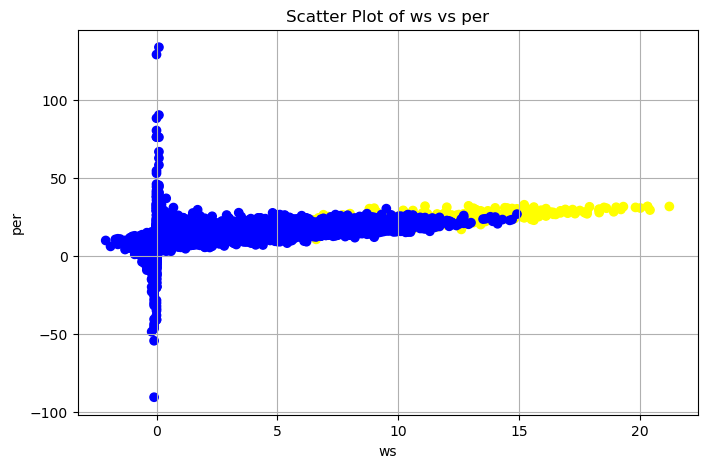

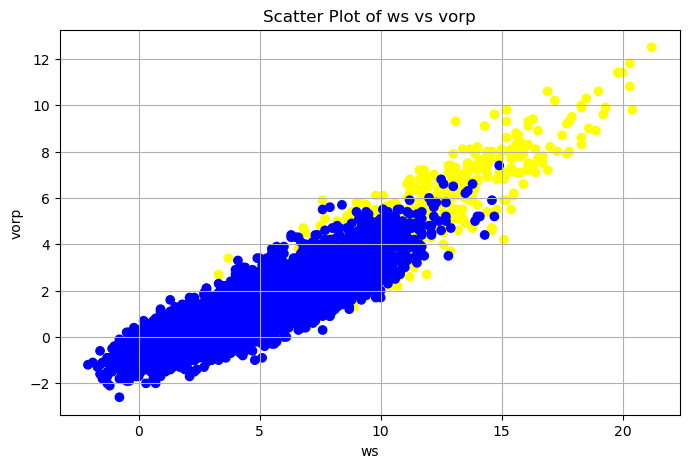

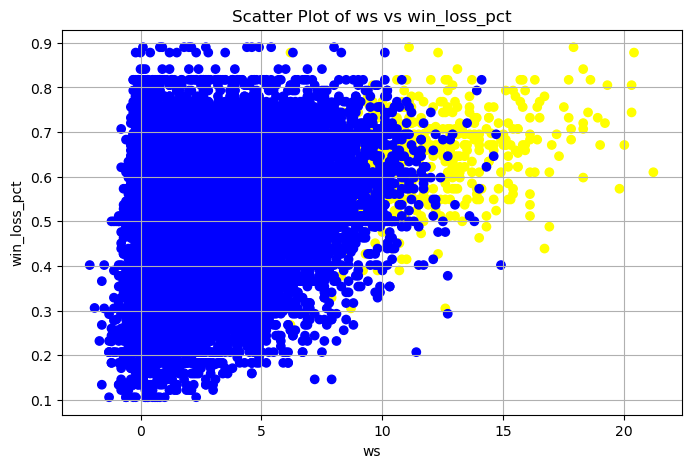

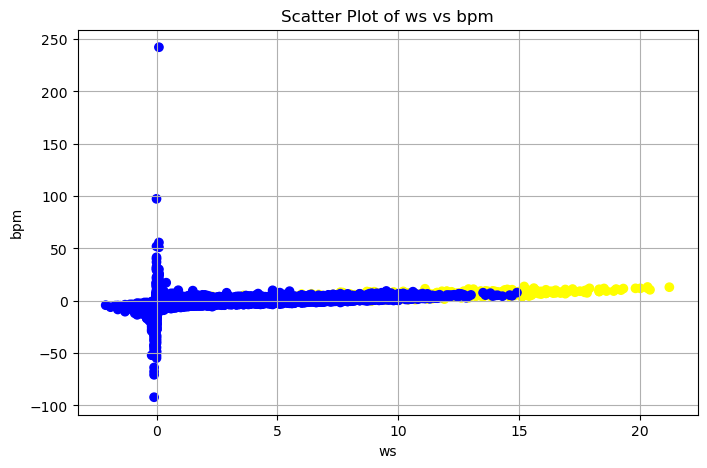

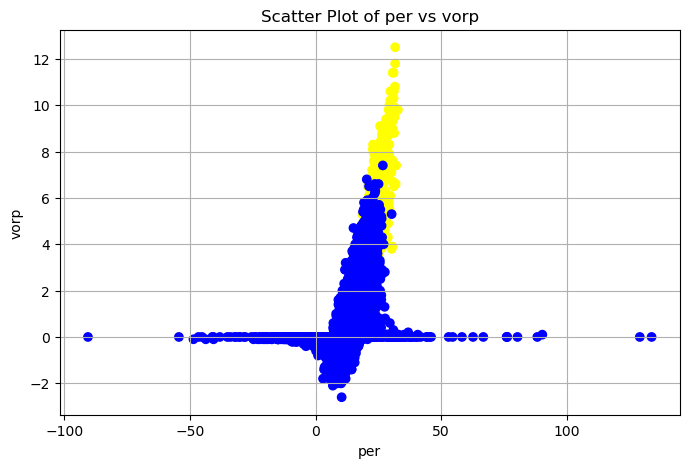

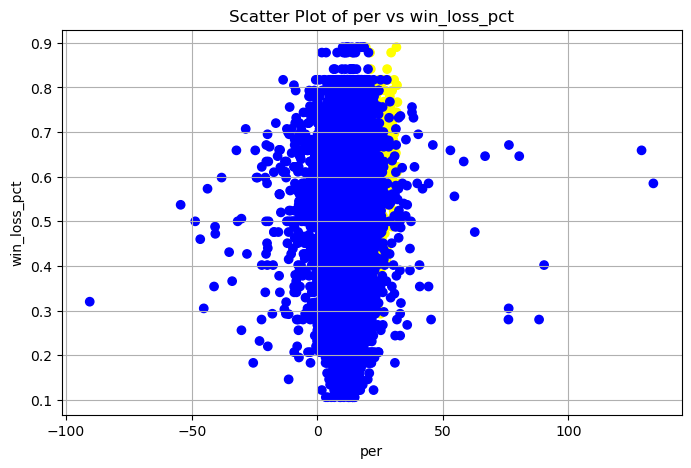

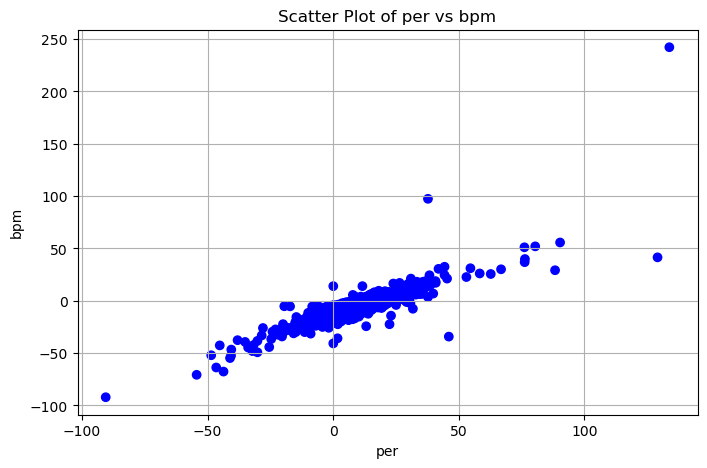

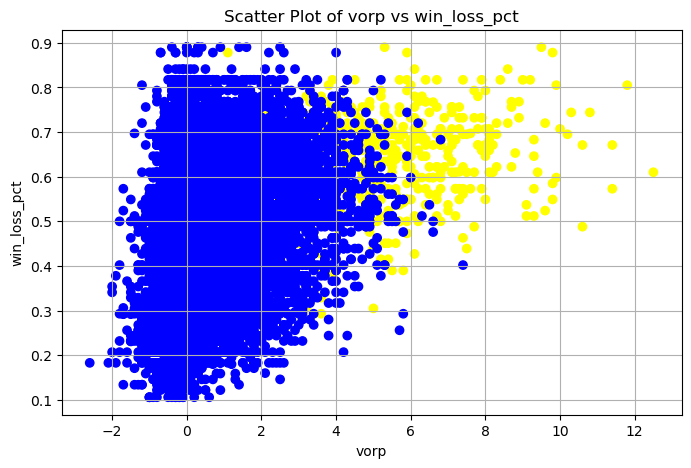

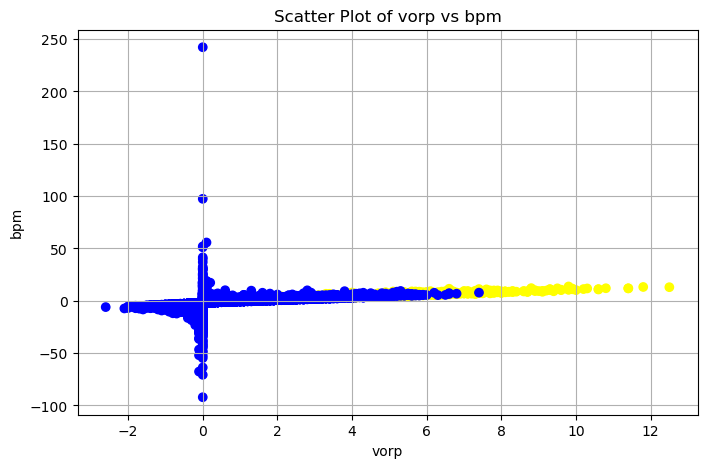

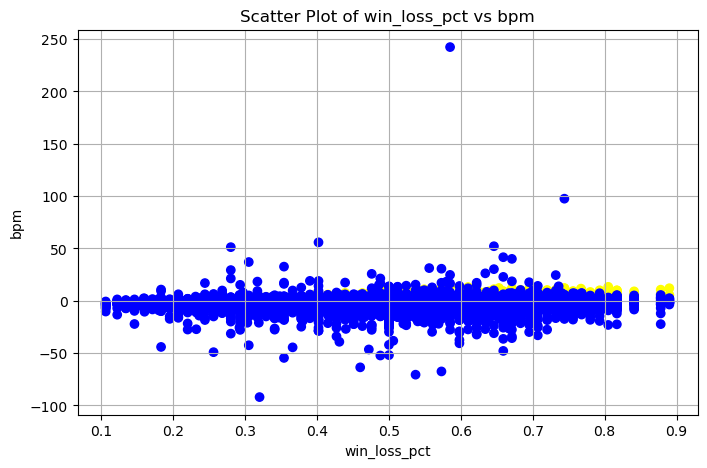

In [52]:
bagres = nba_new[nba_new["award_share"] <= 0]
#amostra de 300 bagres
bagres_amostra = bagres
bagres_amostra = bagres_amostra[["player", "ws", "per", "vorp", "win_loss_pct", "bpm", "award_share"]]

bagres_e_craques = pd.concat([candidatos, bagres_amostra], ignore_index=True)

metrics = ["ws", "per", "vorp", "win_loss_pct", "bpm"]
metric_pairs = list(combinations(metrics, 2))

#azul = bagre
colors = ['yellow' if x > 0 else 'blue' for x in bagres_e_craques['award_share']]

# Loop through each pair of metrics and create a scatter plot
for metric1, metric2 in metric_pairs:
    plt.figure(figsize=(8, 5))  # Optional: specify figure size
    plt.scatter(bagres_e_craques[metric1], bagres_e_craques[metric2], color=colors)
    plt.xlabel(metric1)
    plt.ylabel(metric2)
    plt.title(f'Scatter Plot of {metric1} vs {metric2}')
    plt.grid(True)
    plt.show()

In [53]:
# Dropping rows where any value is missing
bagres_e_craques.dropna(inplace=True)

# Or dropping columns with more than a certain percentage of missing values
threshold = 0.3  # Threshold to drop columns, e.g., if more than 30% values are missing
bagres_e_craques.dropna(axis=1, thresh=int(threshold * len(bagres_e_craques)), inplace=True)

# Replace inf/-inf with NaN (then you can fill NaN as shown above)
bagres_e_craques.replace([np.inf, -np.inf], np.nan, inplace=True)

bagres_e_craques = bagres_e_craques.apply(pd.to_numeric, errors='ignore')

C:\Users\l3598\AppData\Local\Temp\ipykernel_15232\3244935570.py:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  bagres_e_craques = bagres_e_craques.apply(pd.to_numeric, errors='ignore')


### KMeans

In [54]:
# List of metrics to use for clustering
metrics = ["ws", "per", "vorp", "win_loss_pct", "bpm"]

# Create all combinations of metrics for clustering (pairs in this case)
metric_pairs = list(combinations(metrics, 2))

# Loop through each pair of metrics and perform clustering
for metric1, metric2 in metric_pairs:
    print(f'Clustering on: {metric1} and {metric2}')
    
    features = bagres_e_craques[[metric1, metric2]]
    
    X = features.values
    
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(X)
    
    labels = kmeans.predict(X)
    bagres_e_craques['cluster'] = labels
    
    df = bagres_e_craques.copy()
    
    # Calculate 'expected_cluster' based on the condition
    df['expected_cluster'] = (df['award_share'] == 0).astype(int)
    
    # Compare 'expected_cluster' with 'cluster' to determine correct predictions
    df['correct_prediction'] = (df['cluster'] == df['expected_cluster']).astype(int)
    
    # Calculate accuracy
    accuracy = df['correct_prediction'].mean()
    if accuracy > 0.4:
        print(f'Accuracy for {metric1} vs {metric2}: {accuracy * 100:.2f}%\n')
    else:
        accuracy  = 1 - accuracy
        print(f'Accuracy for {metric1} vs {metric2}: {accuracy * 100:.2f}%\n')

Clustering on: ws and per
Accuracy for ws vs per: 43.31%

Clustering on: ws and vorp
Accuracy for ws vs vorp: 80.40%

Clustering on: ws and win_loss_pct
Accuracy for ws vs win_loss_pct: 77.42%

Clustering on: ws and bpm
Accuracy for ws vs bpm: 60.87%

Clustering on: per and vorp
Accuracy for per vs vorp: 48.70%

Clustering on: per and win_loss_pct
Accuracy for per vs win_loss_pct: 47.81%

Clustering on: per and bpm
Accuracy for per vs bpm: 42.45%

Clustering on: vorp and win_loss_pct
Accuracy for vorp vs win_loss_pct: 88.62%

Clustering on: vorp and bpm
Accuracy for vorp vs bpm: 60.58%

Clustering on: win_loss_pct and bpm
Accuracy for win_loss_pct vs bpm: 64.17%



### CMeans

In [55]:
from skfuzzy.cluster import cmeans, cmeans_predict
# Loop por cada par de métricas e realizar o clustering
for metric1, metric2 in metric_pairs:
    print(f'Clustering on: {metric1} and {metric2}')
    
    features = bagres_e_craques[[metric1, metric2]]
    X = features.values.T  # Transpor para a forma esperada pelo cmeans
    
    # Realizar o clustering com cmeans
    cntr, u, u0, d, jm, p, fpc = cmeans(data=X, c=2, m=2, error=0.005, maxiter=1000, init=None)
    
    # Prever os clusters
    u, u0, d, jm, p, fpc = cmeans_predict(X, cntr, m=2, error=0.005, maxiter=1000)
    labels = np.argmax(u, axis=0)
    
    # Adicionar os rótulos de cluster ao DataFrame
    bagres_e_craques['cluster'] = labels
    
    df = bagres_e_craques.copy()
    
    # Calcular 'expected_cluster' baseado na condição
    df['expected_cluster'] = (df['award_share'] == 0).astype(int)
    
    # Comparar 'expected_cluster' com 'cluster' para determinar previsões corretas
    df['correct_prediction'] = (df['cluster'] == df['expected_cluster']).astype(int)
    
    # Calcular a acurácia
    accuracy = df['correct_prediction'].mean()
    if accuracy > 0.4:
        print(f'Accuracy for {metric1} vs {metric2}: {accuracy * 100:.2f}%\n')
    else:
        accuracy  = 1 - accuracy
        print(f'Accuracy for {metric1} vs {metric2}: {accuracy * 100:.2f}%\n')

Clustering on: ws and per
Accuracy for ws vs per: 57.50%

Clustering on: ws and vorp
Accuracy for ws vs vorp: 78.39%

Clustering on: ws and win_loss_pct
Accuracy for ws vs win_loss_pct: 76.61%

Clustering on: ws and bpm
Accuracy for ws vs bpm: 60.47%

Clustering on: per and vorp
Accuracy for per vs vorp: 47.20%

Clustering on: per and win_loss_pct
Accuracy for per vs win_loss_pct: 50.68%

Clustering on: per and bpm
Accuracy for per vs bpm: 47.73%

Clustering on: vorp and win_loss_pct
Accuracy for vorp vs win_loss_pct: 86.57%

Clustering on: vorp and bpm
Accuracy for vorp vs bpm: 47.28%

Clustering on: win_loss_pct and bpm
Accuracy for win_loss_pct vs bpm: 42.03%

